In [57]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image


masses = [3, 4, 4.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5]
lifetimes = {1:0, 10:1, 100:2}

def set_bin_content(mass, lifetime, value, arr):
    ybin = np.max(np.digitize(mass, masses)-1, 0)
    xbin = lifetimes[lifetime]
    arr[ybin,xbin] = value

def calculate_tree_syst(nominal_tree, variation_tree):
    model = 'model_weight_one_dirac_hnl_LNC_single_flavour_mixing' # yes this is arbitrary, and yes it does change the return value
    # make histograms
    n_nom, bins_nom = np.histogram(nominal_tree['HNLm'].array(), bins=np.linspace(0,100,100), weights=nominal_tree[model].array() * nominal_tree['SF_nominal'].array())
    n_var, bins_var = np.histogram(variation_tree['HNLm'].array(), bins=np.linspace(0,100,100), weights=variation_tree[model].array() * variation_tree['SF_nominal'].array())
    bin_width = bins_nom[1] - bins_nom[0] # should be the same as var

    # sum over number in each bin and mult by bin width, which can be factored out
    integral_nom = bin_width * sum(n_nom)
    integral_var = bin_width * sum(n_var)

    syst = abs((integral_nom - integral_var) / integral_nom )

    return syst

def make_uncertainty_plot(histpath, title):

    uncertianty_arr = np.array([
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    ])

    count_arr = np.array(uncertianty_arr)

    # get bins from ntuples    
    for hist_file in glob.glob(histpath):

        f_fullrun2 = uproot.open(hist_file)
        uncertainty_value = -100
        passed_events = -100
        try:
            # take the per-event difference in systematics
            if 'nominal' in sys_of_interest:
                nominal_tree = f_fullrun2[f'nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']
                down_tree = f_fullrun2[f'{sys_of_interest}__1up_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']
                up_tree = f_fullrun2[f'{sys_of_interest}__1down_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']
                up_variation = calculate_tree_syst(nominal_tree, up_tree)
                down_variation = calculate_tree_syst(nominal_tree, down_tree)
                uncertainty_value = max(up_variation, down_variation) # maximum symmetrization used in limits
            elif '_EFF_' in sys_of_interest:
                nominal = f_fullrun2['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['SF_nominal'].array()
                down = f_fullrun2['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL'][f'SF_{sys_of_interest}__1down'].array()
                up = f_fullrun2['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL'][f'SF_{sys_of_interest}__1up'].array()
                uncertainty_value = max(abs(nominal-up).mean(), abs(nominal-down).mean()) # maximum symmetrization used in limits
            elif '_1DOWN' in sys_of_interest:
                uncertainty_value = 1 - f_fullrun2['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL'][sys_of_interest].array().mean()
            else:
                raise Exception('systematic not identified')
            passed_events = len(f_fullrun2['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['SF_nominal'])
        except Exception as e:
            # print('failure', hist_file)
            # print(e)
            pass

        tokens = hist_file.split('/')[5].split('_')
        file_lifetime = int(tokens[3].split('mm')[0])
        file_mass = float(tokens[2][:-1].replace('p','.'))
        set_bin_content(file_mass, file_lifetime, uncertainty_value, uncertianty_arr)
        set_bin_content(file_mass, file_lifetime, passed_events, count_arr)

    return uncertianty_arr, count_arr

DO_DISPLAY = False

uncertianty_arr_dict = {}
count_arr_dict = {}

for sys_of_interest in [
                        # weights
                        'vertexing_1DOWN',
                        'd0_extrapolation_1DOWN',
                        # SFs
                        'MUON_EFF_RECO_SYS',
                        'MUON_EFF_RECO_SYS_LOWPT',
                        'MUON_EFF_TrigSystUncertainty',
                        'EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR',
                        'EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR',
                        'EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR',
                        # trees
                        'nominalMUON_ID',
                        'nominalMUON_MS',
                        'nominalMUON_SAGITTA_RESBIAS',
                        'nominalMUON_SAGITTA_RHO',
                        'nominalMUON_SCALE',
                        'nominalEG_RESOLUTION_ALL',
                        'nominalEG_SCALE_AF2',
                        'nominalEG_SCALE_ALL',
                        ]:

    if 'nominal' in sys_of_interest:
        TREE_SYSTEMATIC = True
    else:
        TREE_SYSTEMATIC = False

                        
    # fig, axs = plt.subplots(2, 2, figsize=[14,16])

    uncertianty_arr_list = []
    count_arr_list = []

    print(sys_of_interest, 'uuu')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_uuu.root', title=f'{sys_of_interest} μμμ')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/uuu_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'uue')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_uue.root', title=f'{sys_of_interest} μμe')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/uue_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'eeu')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_eeu.root', title=f'{sys_of_interest} eeμ')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/eeu_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'eee')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_eee.root', title=f'{sys_of_interest} eee')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/eee_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'uee')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_uee.root', title=f'{sys_of_interest} μee')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/uee_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'euu')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_euu.root', title=f'{sys_of_interest} eμμ')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/euu_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)


    # plt.savefig('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/'+sys_of_interest+'.png', dpi=300)
    # plt.savefig('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/pdf/'+sys_of_interest+'.pdf', dpi=300)

    uncertianty_arr_dict[sys_of_interest] = uncertianty_arr_list
    count_arr_dict[sys_of_interest] = count_arr_list

# import glob
# import os
# import PyPDF2

# merger = PyPDF2.PdfFileMerger()

# for f in sorted(glob.glob('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/pdf/*'), key=os.path.getmtime):
#     # print(f)
#     merger.append(f)

# merger.write("/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/result.pdf")
# merger.close()


vertexing_1DOWN uuu
vertexing_1DOWN uue
vertexing_1DOWN eeu
vertexing_1DOWN eee
vertexing_1DOWN uee
vertexing_1DOWN euu
d0_extrapolation_1DOWN uuu
d0_extrapolation_1DOWN uue
d0_extrapolation_1DOWN eeu
d0_extrapolation_1DOWN eee
d0_extrapolation_1DOWN uee
d0_extrapolation_1DOWN euu
MUON_EFF_RECO_SYS uuu
MUON_EFF_RECO_SYS uue
MUON_EFF_RECO_SYS eeu
MUON_EFF_RECO_SYS eee
MUON_EFF_RECO_SYS uee
MUON_EFF_RECO_SYS euu
MUON_EFF_RECO_SYS_LOWPT uuu
MUON_EFF_RECO_SYS_LOWPT uue
MUON_EFF_RECO_SYS_LOWPT eeu
MUON_EFF_RECO_SYS_LOWPT eee
MUON_EFF_RECO_SYS_LOWPT uee
MUON_EFF_RECO_SYS_LOWPT euu
MUON_EFF_TrigSystUncertainty uuu
MUON_EFF_TrigSystUncertainty uue
MUON_EFF_TrigSystUncertainty eeu
MUON_EFF_TrigSystUncertainty eee
MUON_EFF_TrigSystUncertainty uee
MUON_EFF_TrigSystUncertainty euu
EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR uuu
EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR uue
EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR eeu
EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR eee
EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR uee
EL_EFF_Reco_TOTAL_1N

In [58]:
# uncertianty_arr_dict_backup = uncertianty_arr_dict
# print(uncertianty_arr_dict_new)
# uncertianty_arr_dict_new.update(/)
# import json
# print(json.dumps(uncertianty_arr_dict), file=open('uncertianty_arr_dict.json', 'w'))

# outfile = 'uncertianty_arr_dict.npz'
# np.savez(outfile, **uncertianty_arr_dict)

# npzfile = np.load(outfile)
# print('npzfile.files: {}'.format(npzfile.files))
# print('npzfile["MUON_EFF_RECO_SYS"]: {}'.format(npzfile["MUON_EFF_RECO_SYS"]))
uncertianty_arr_dict_backup = dict(uncertianty_arr_dict)

/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.
/home/newhouse/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Fixe

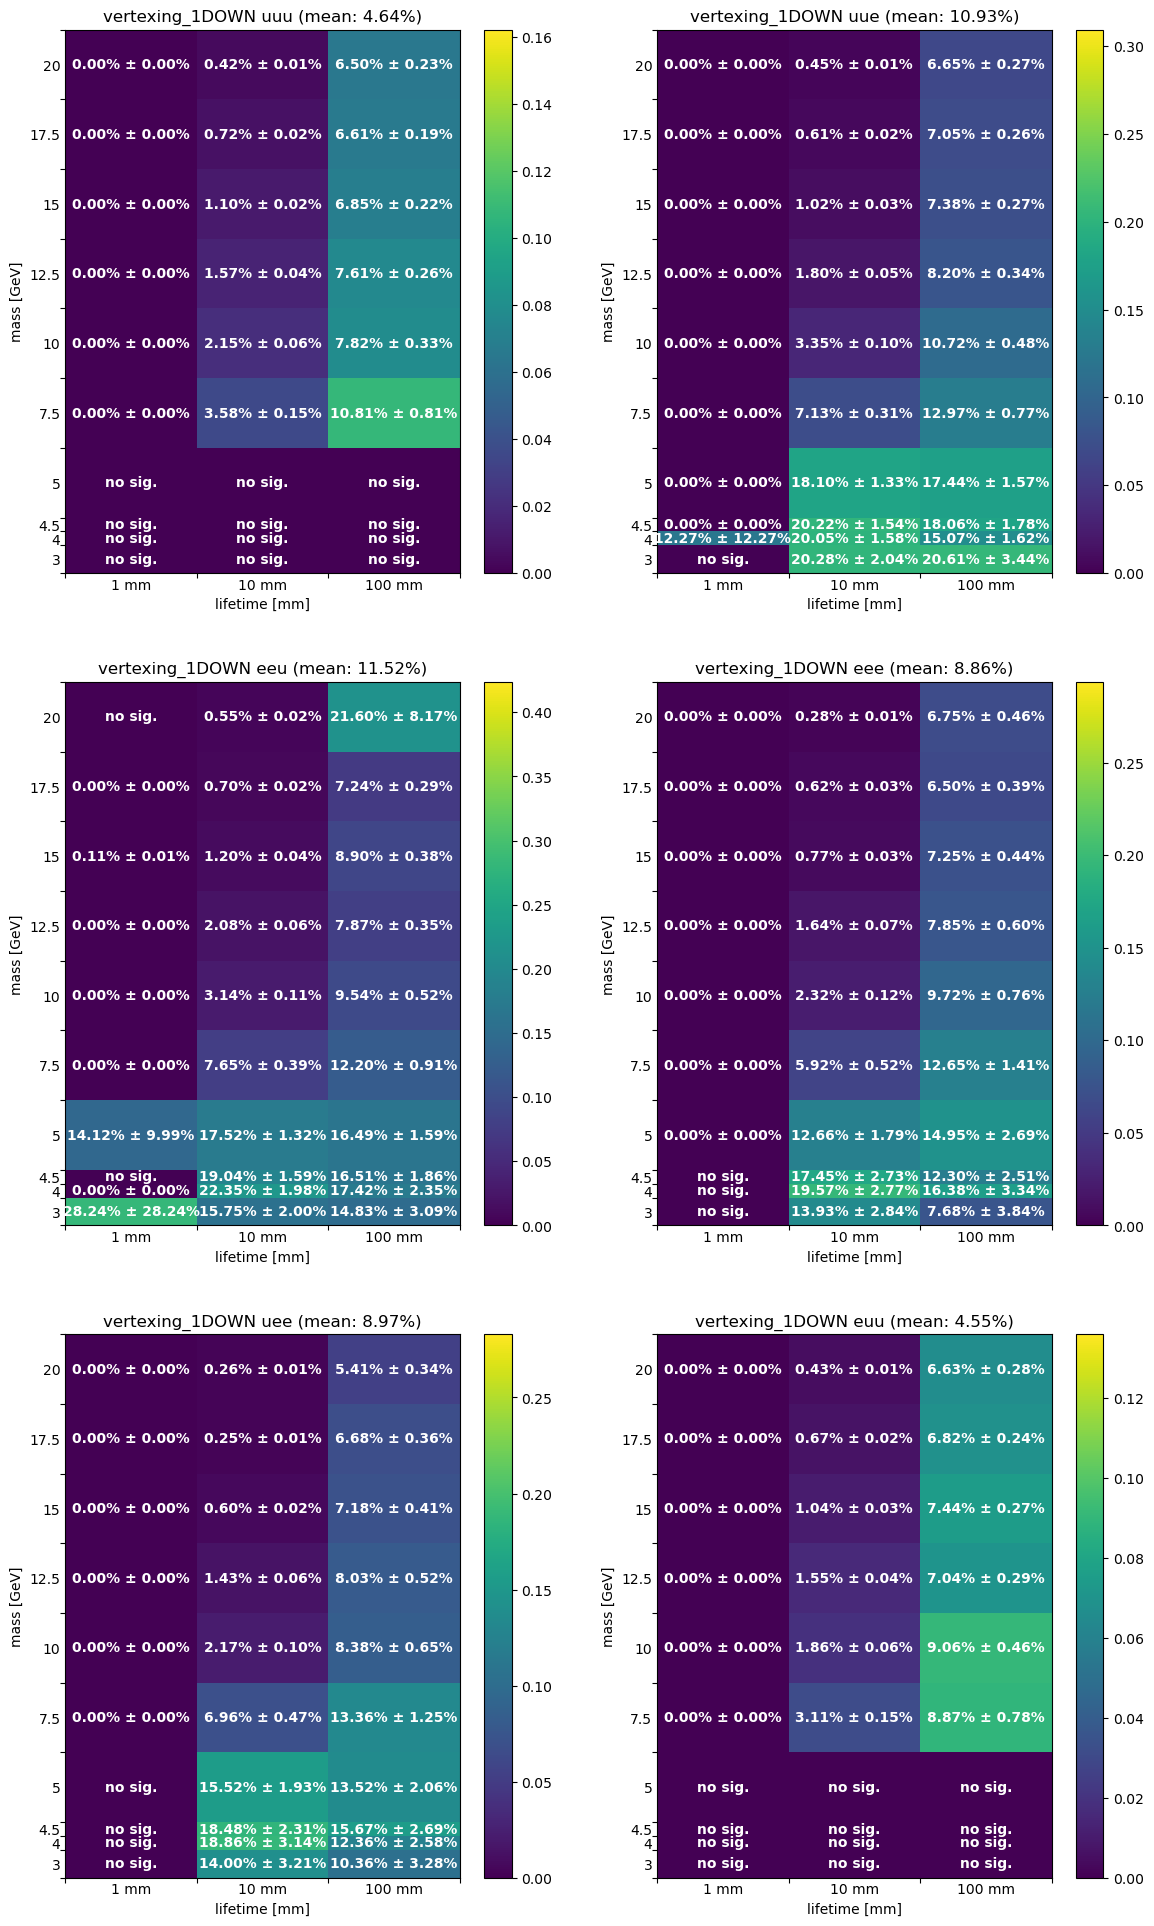

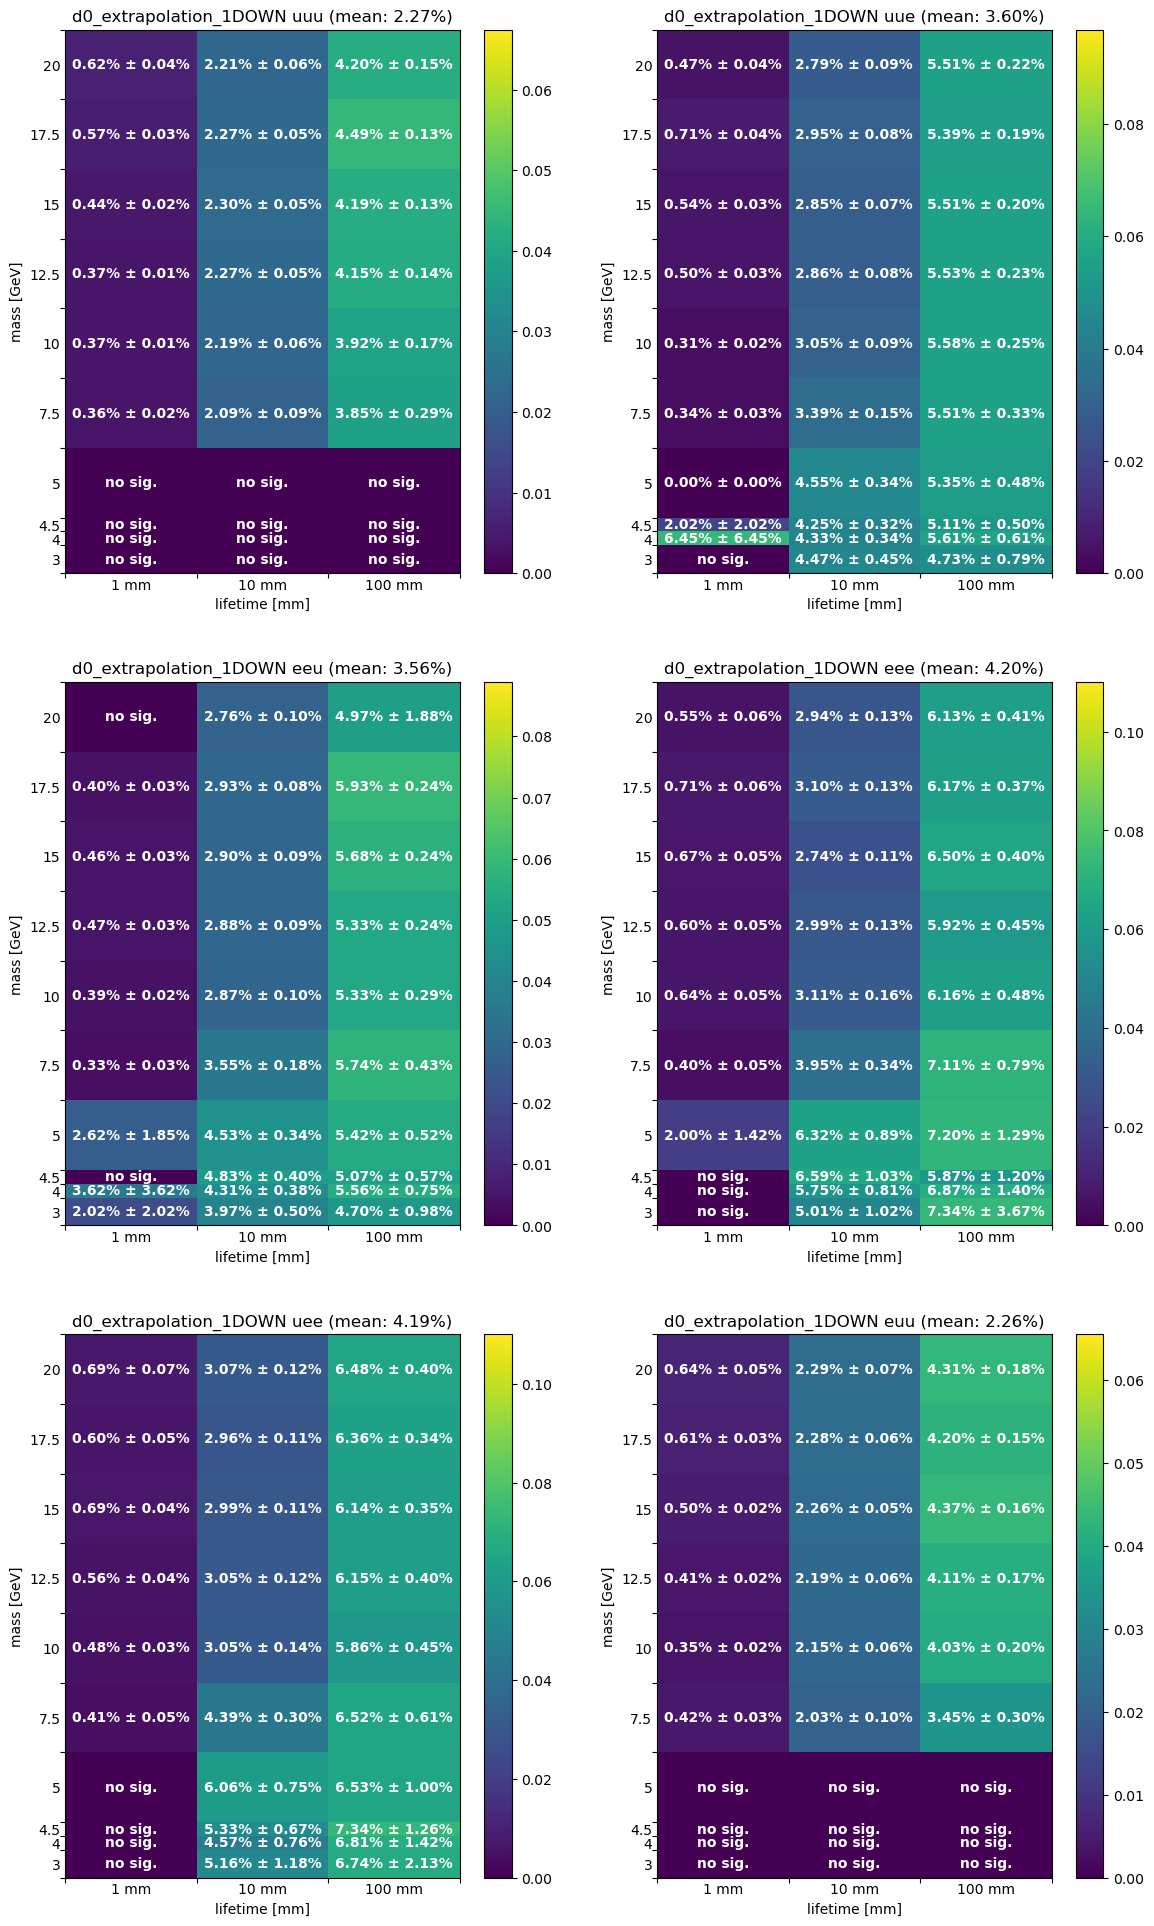

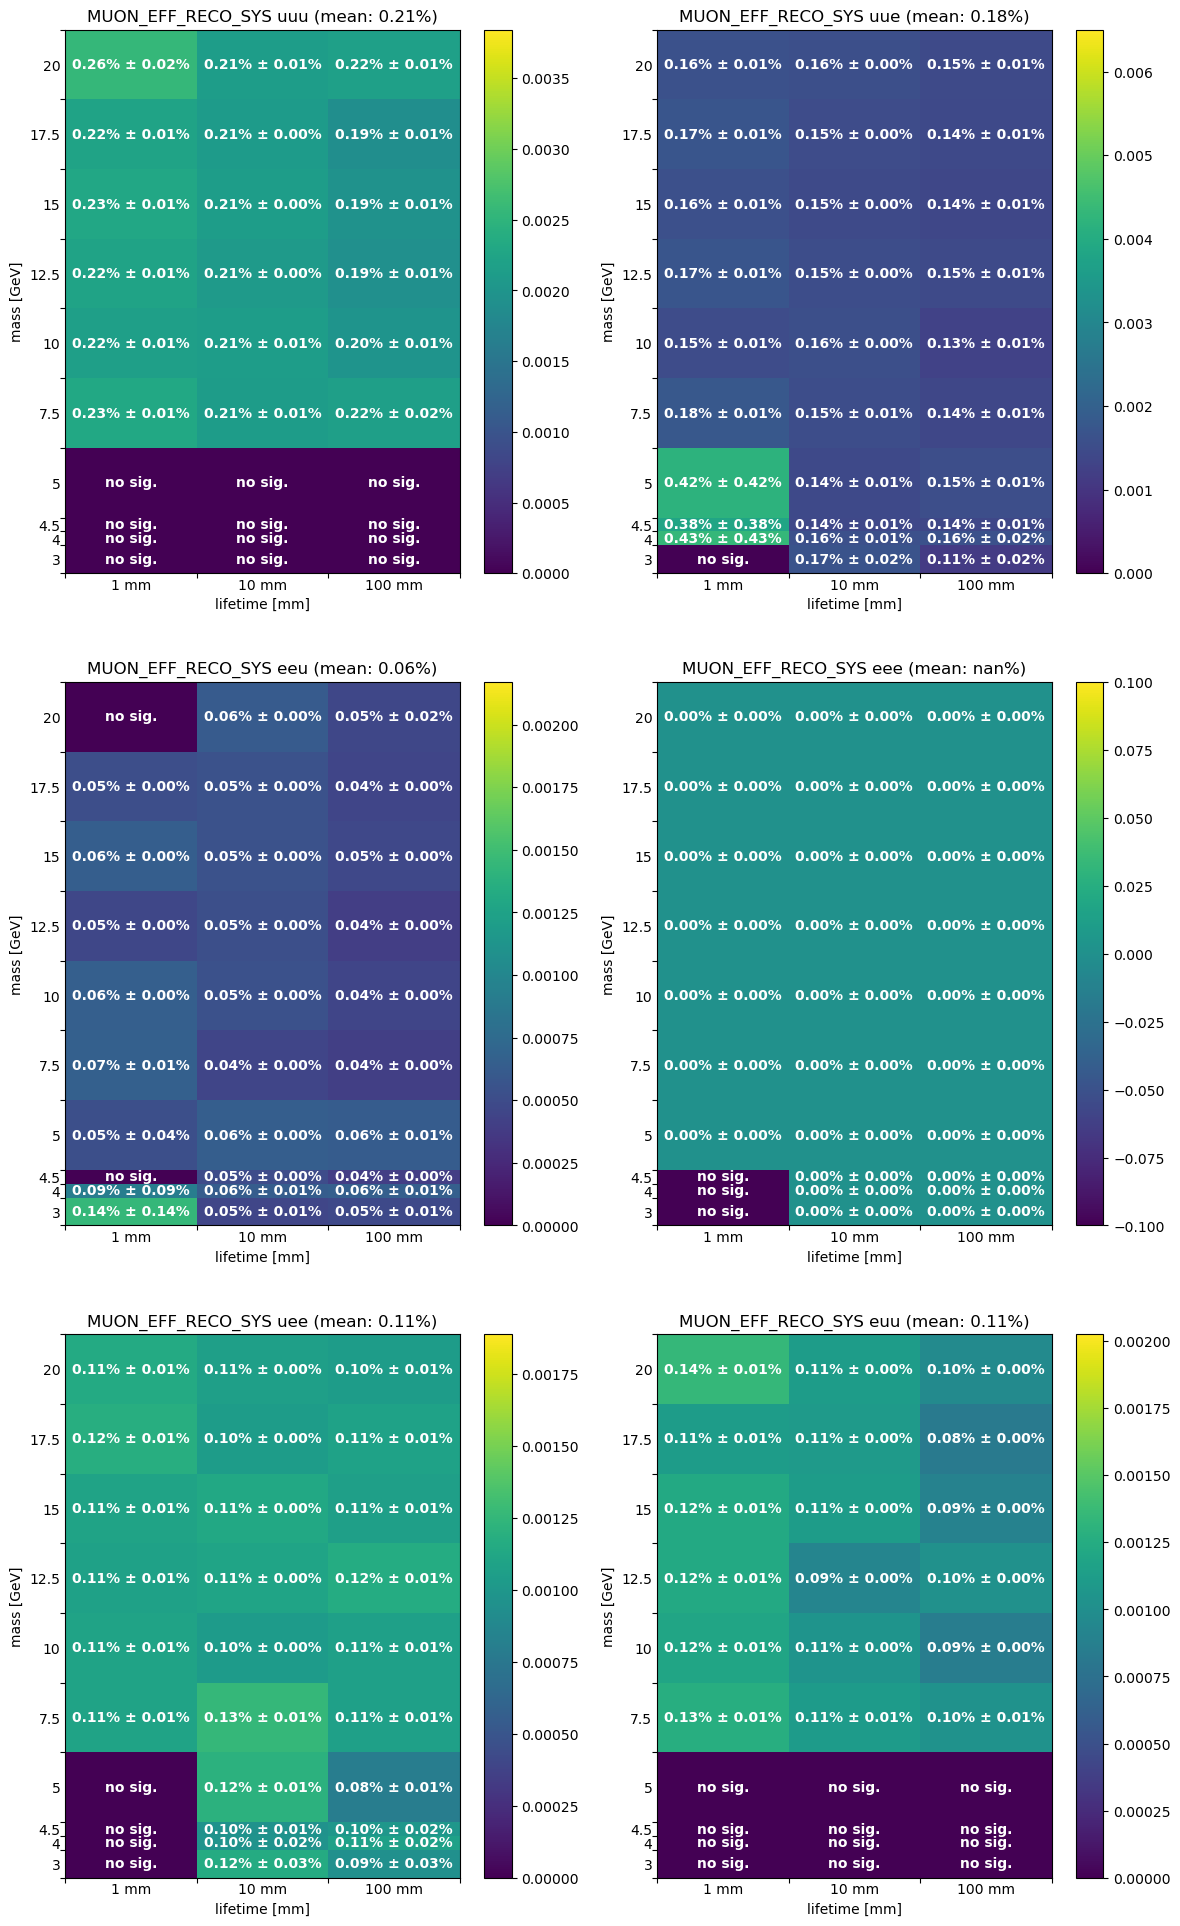

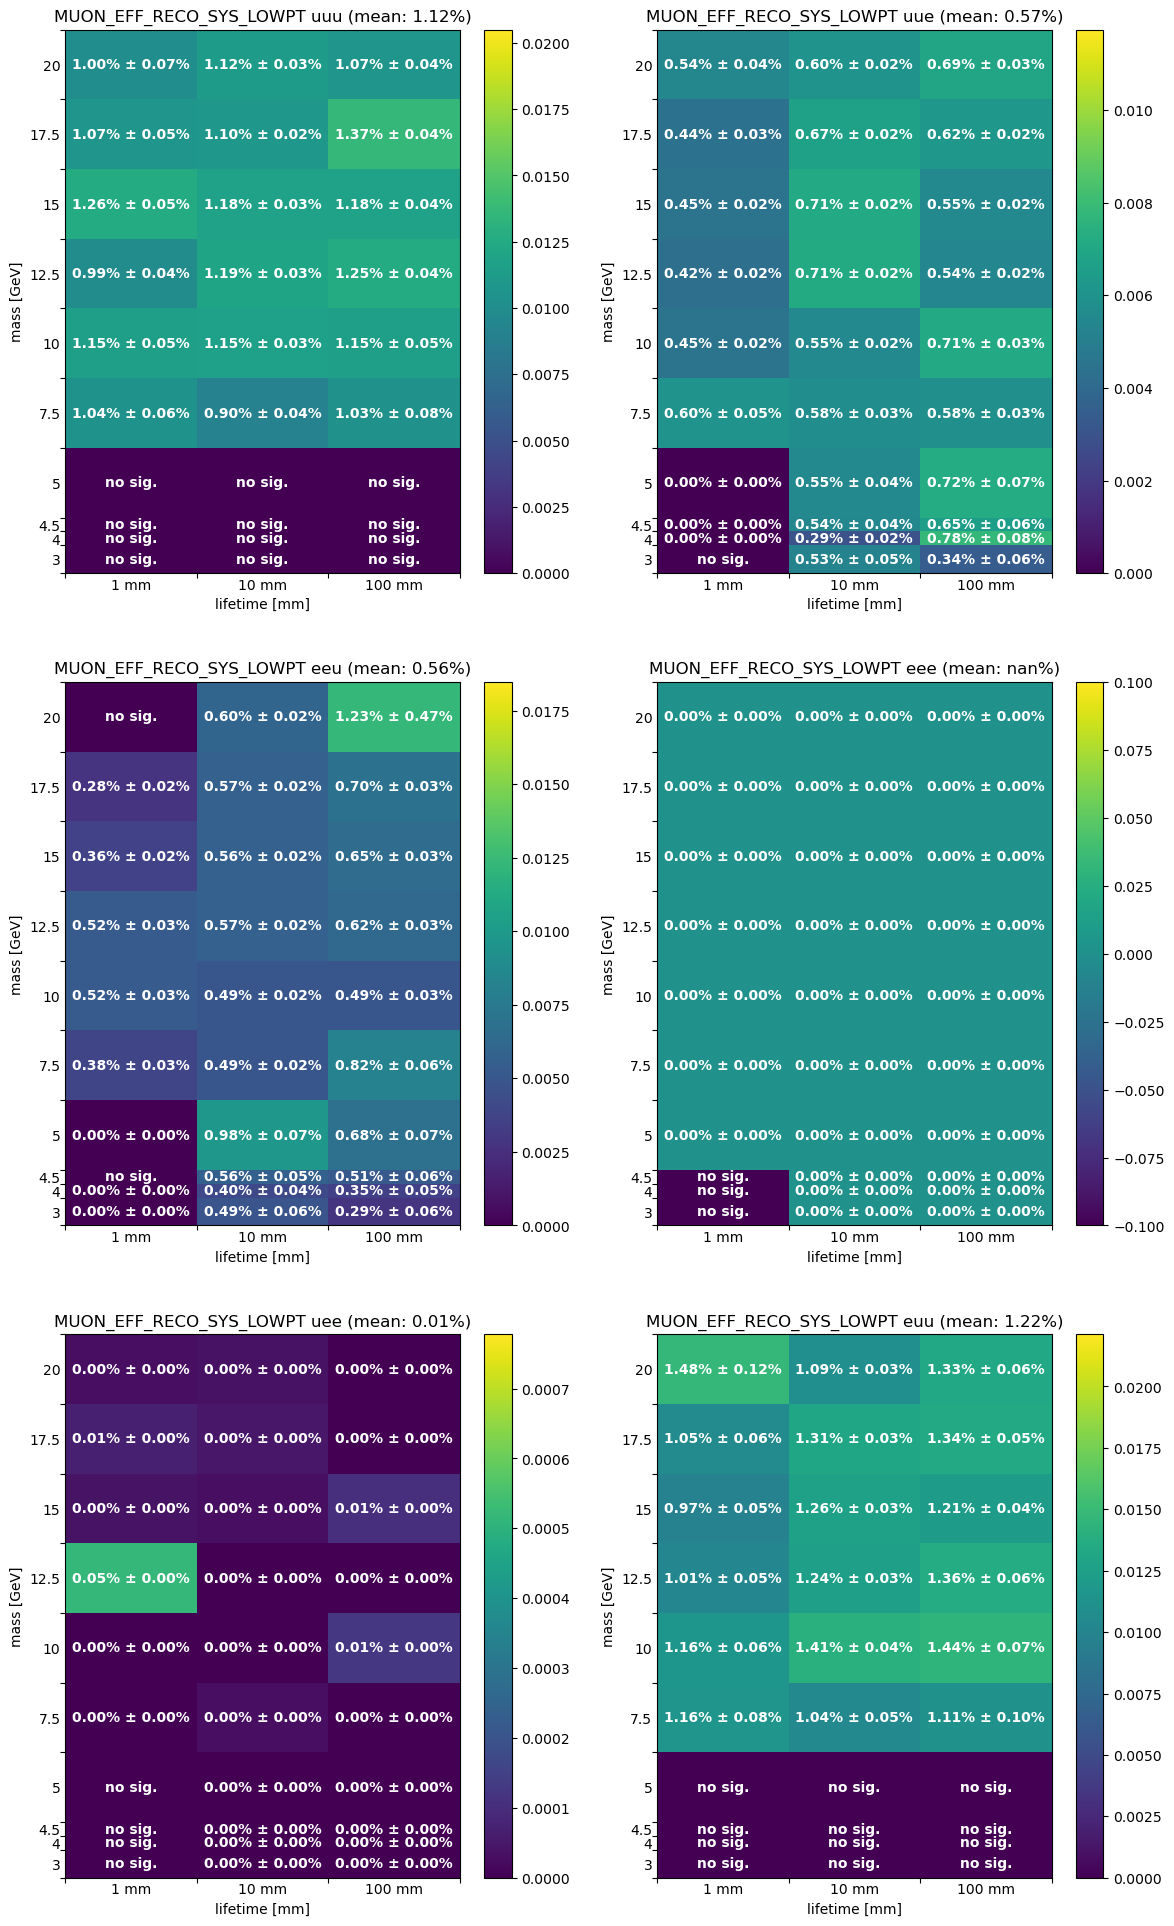

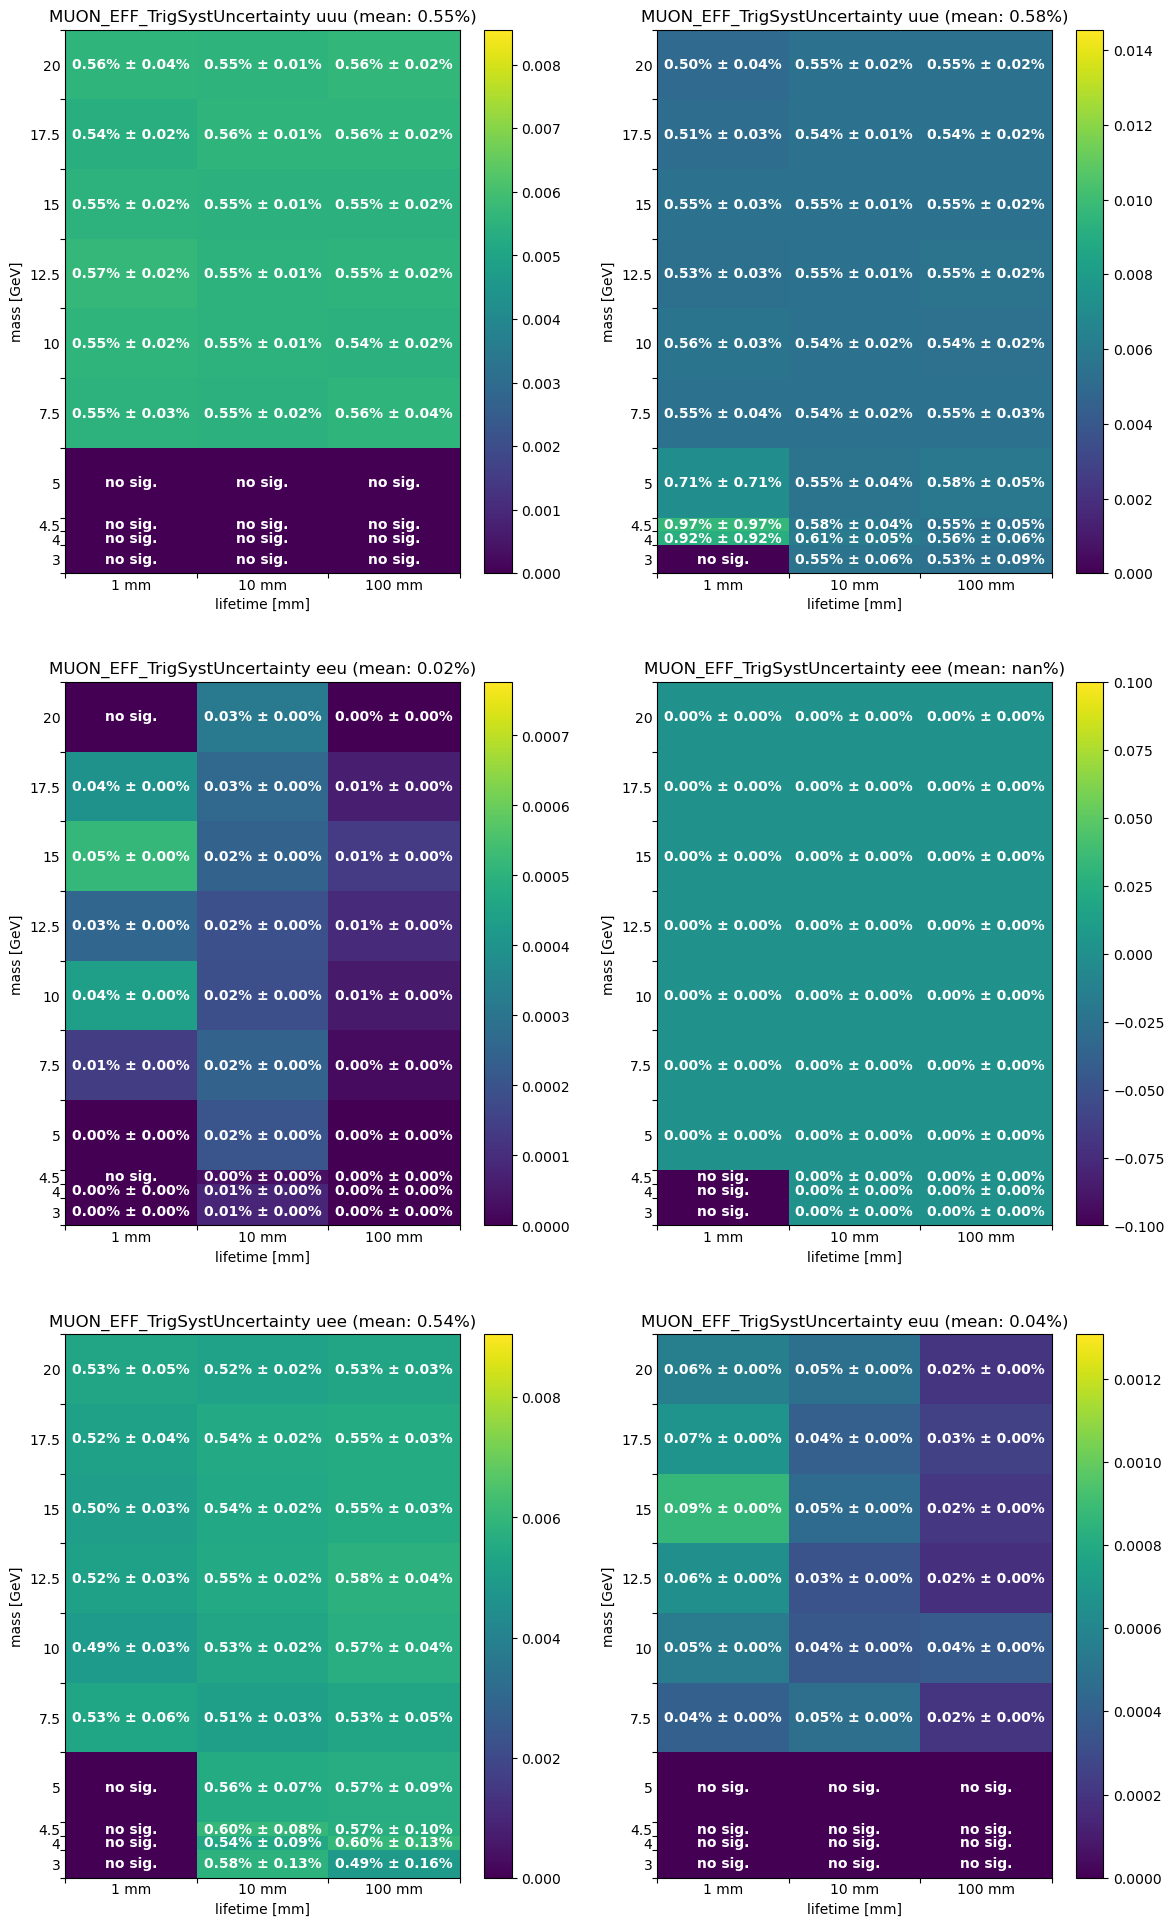

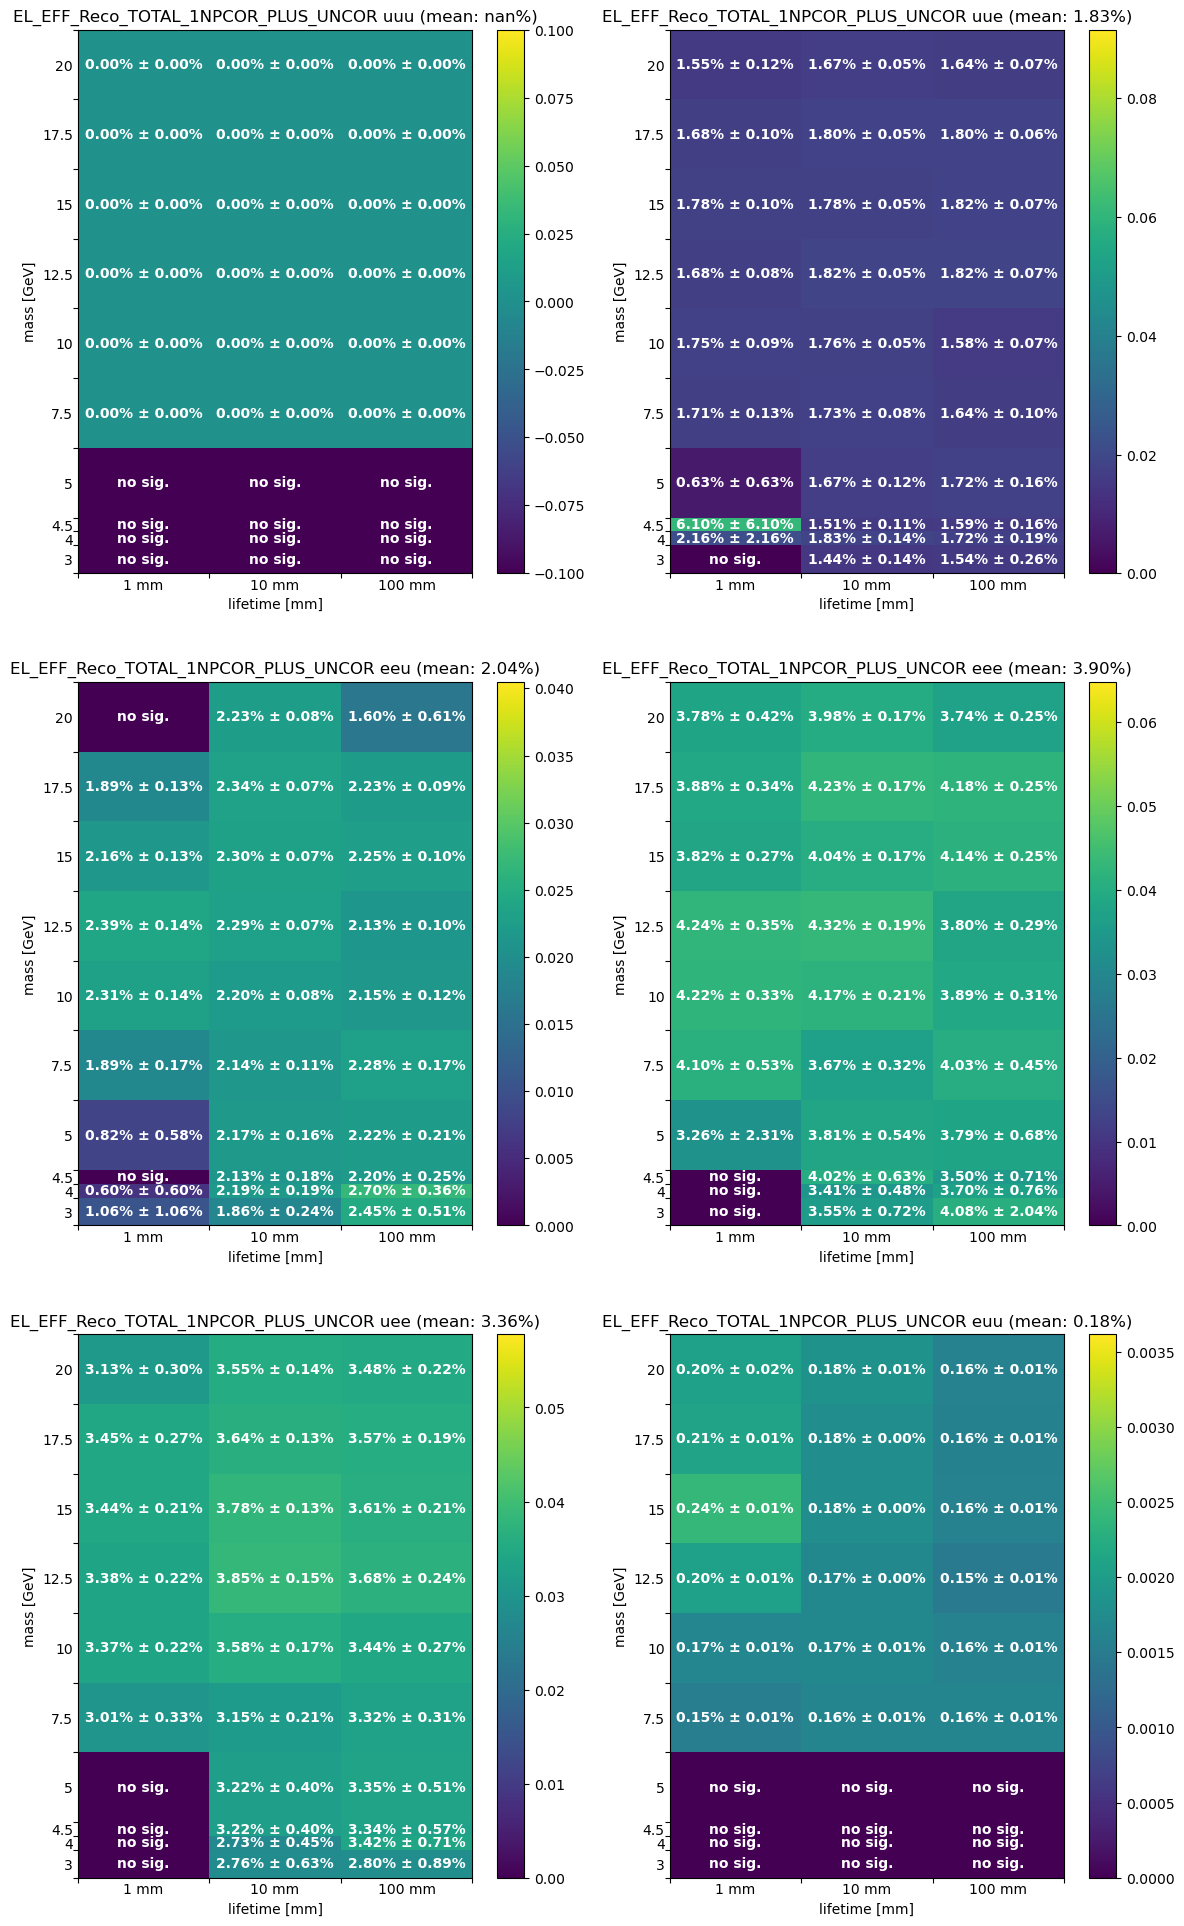

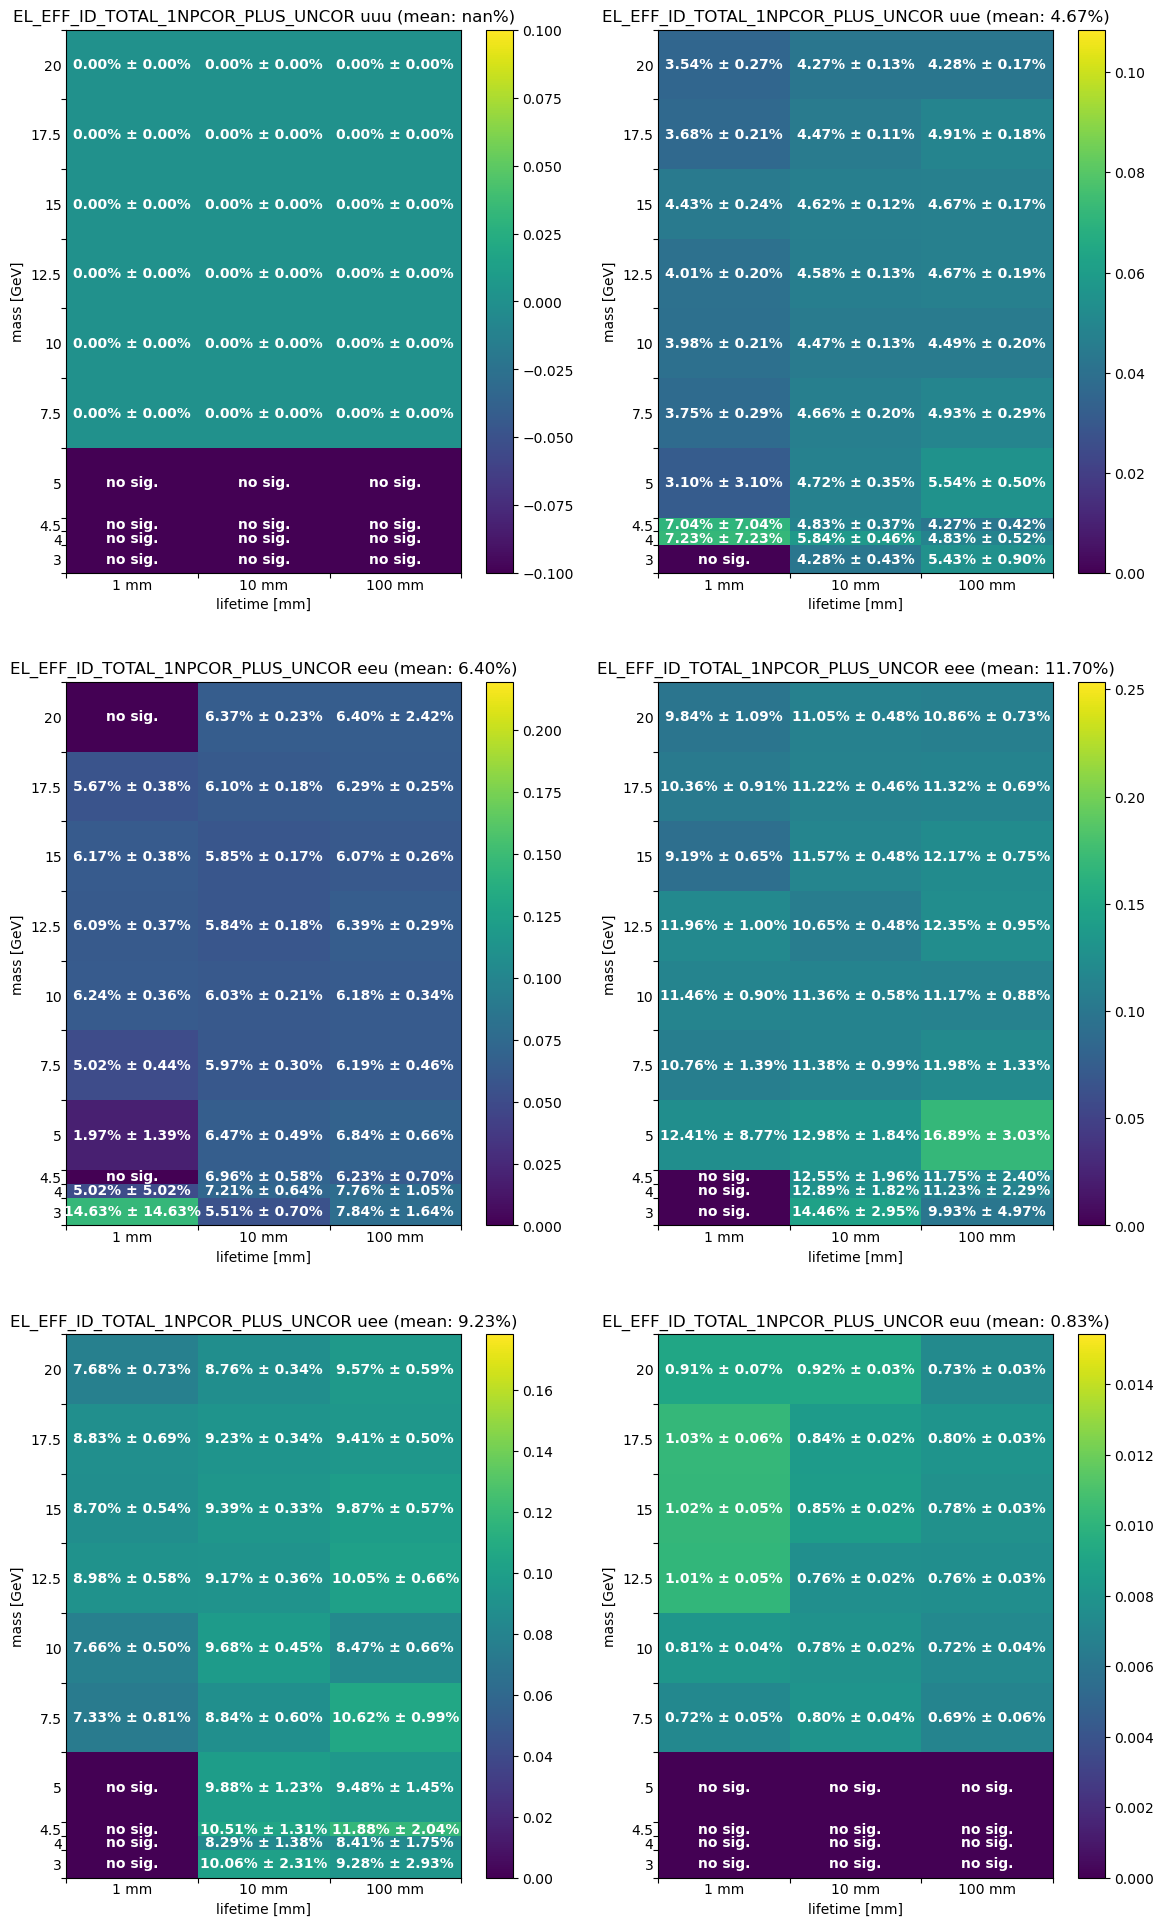

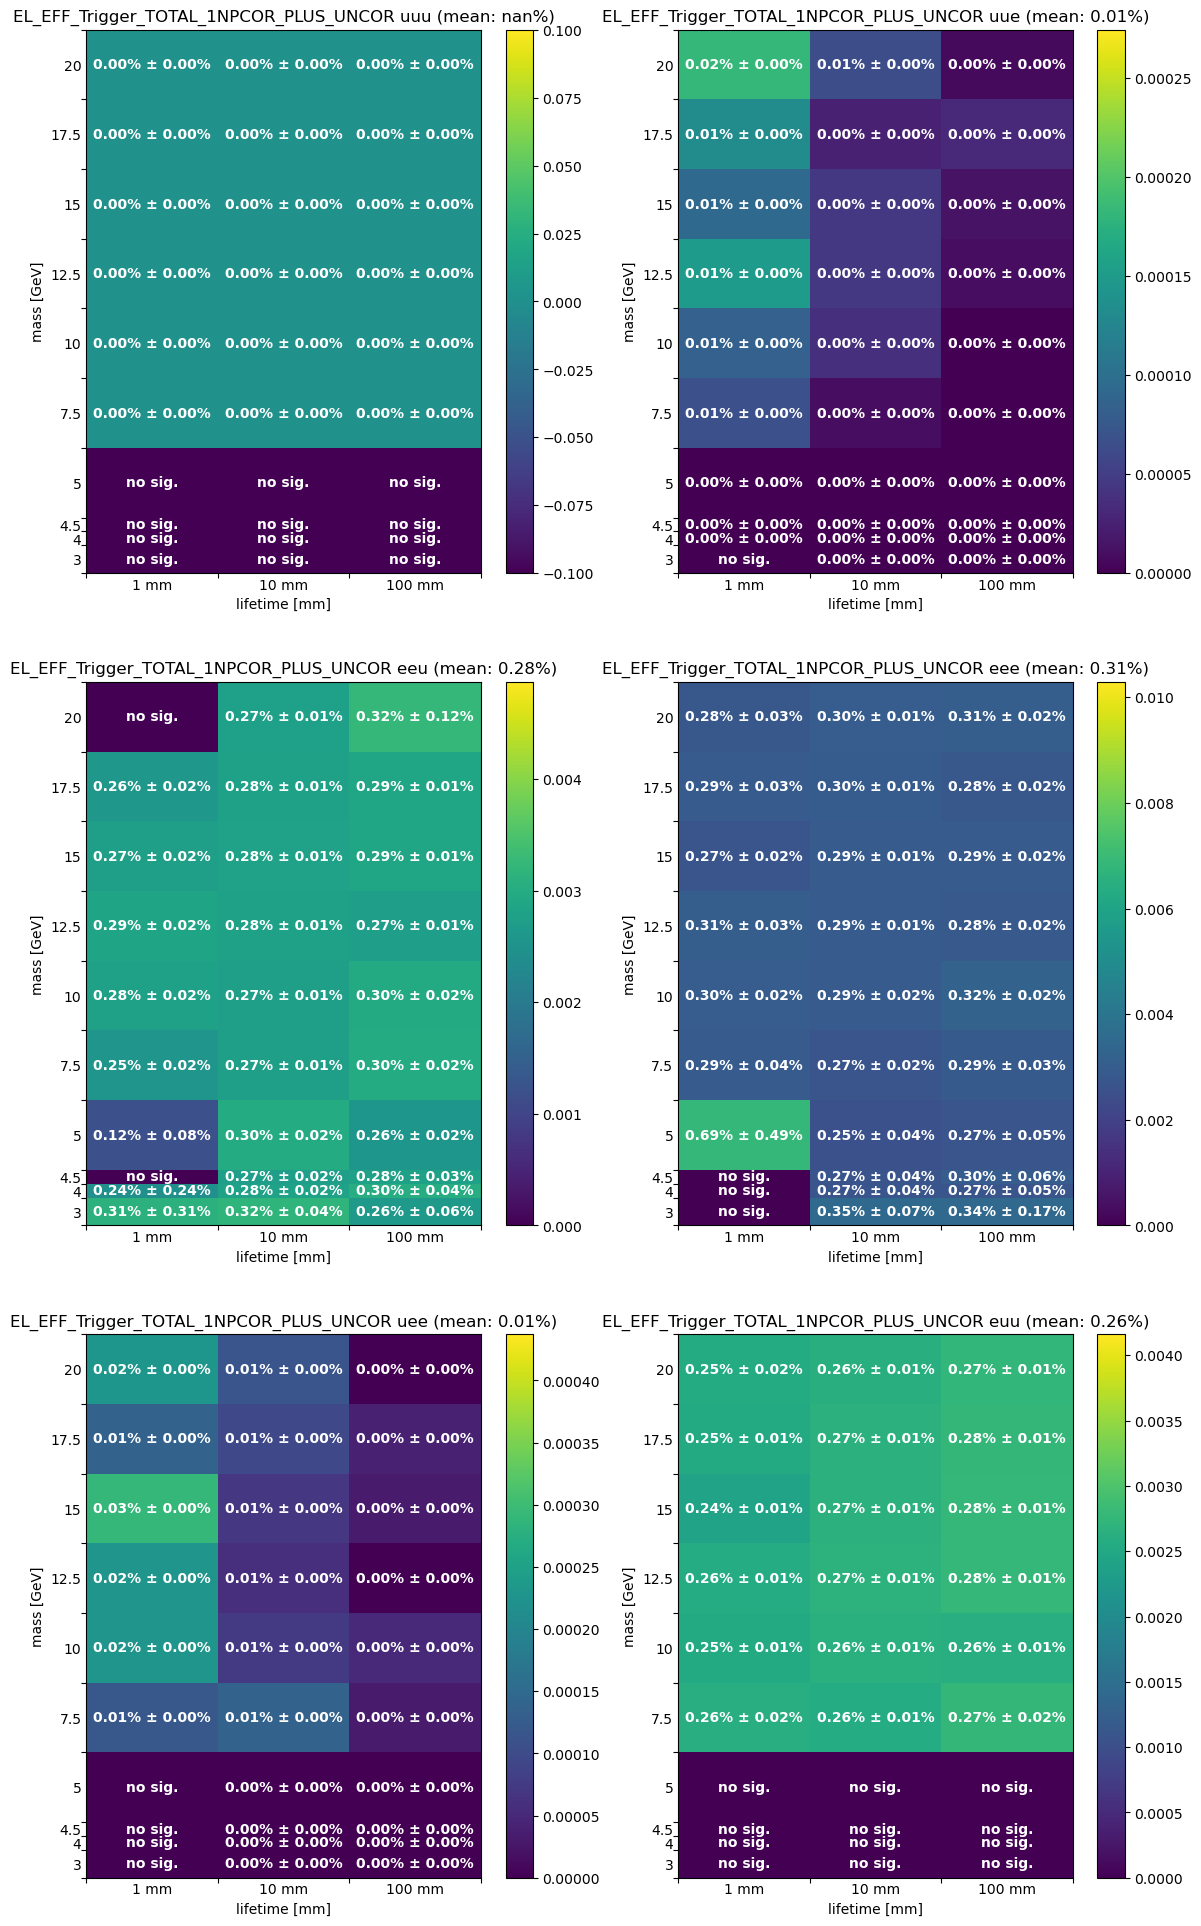

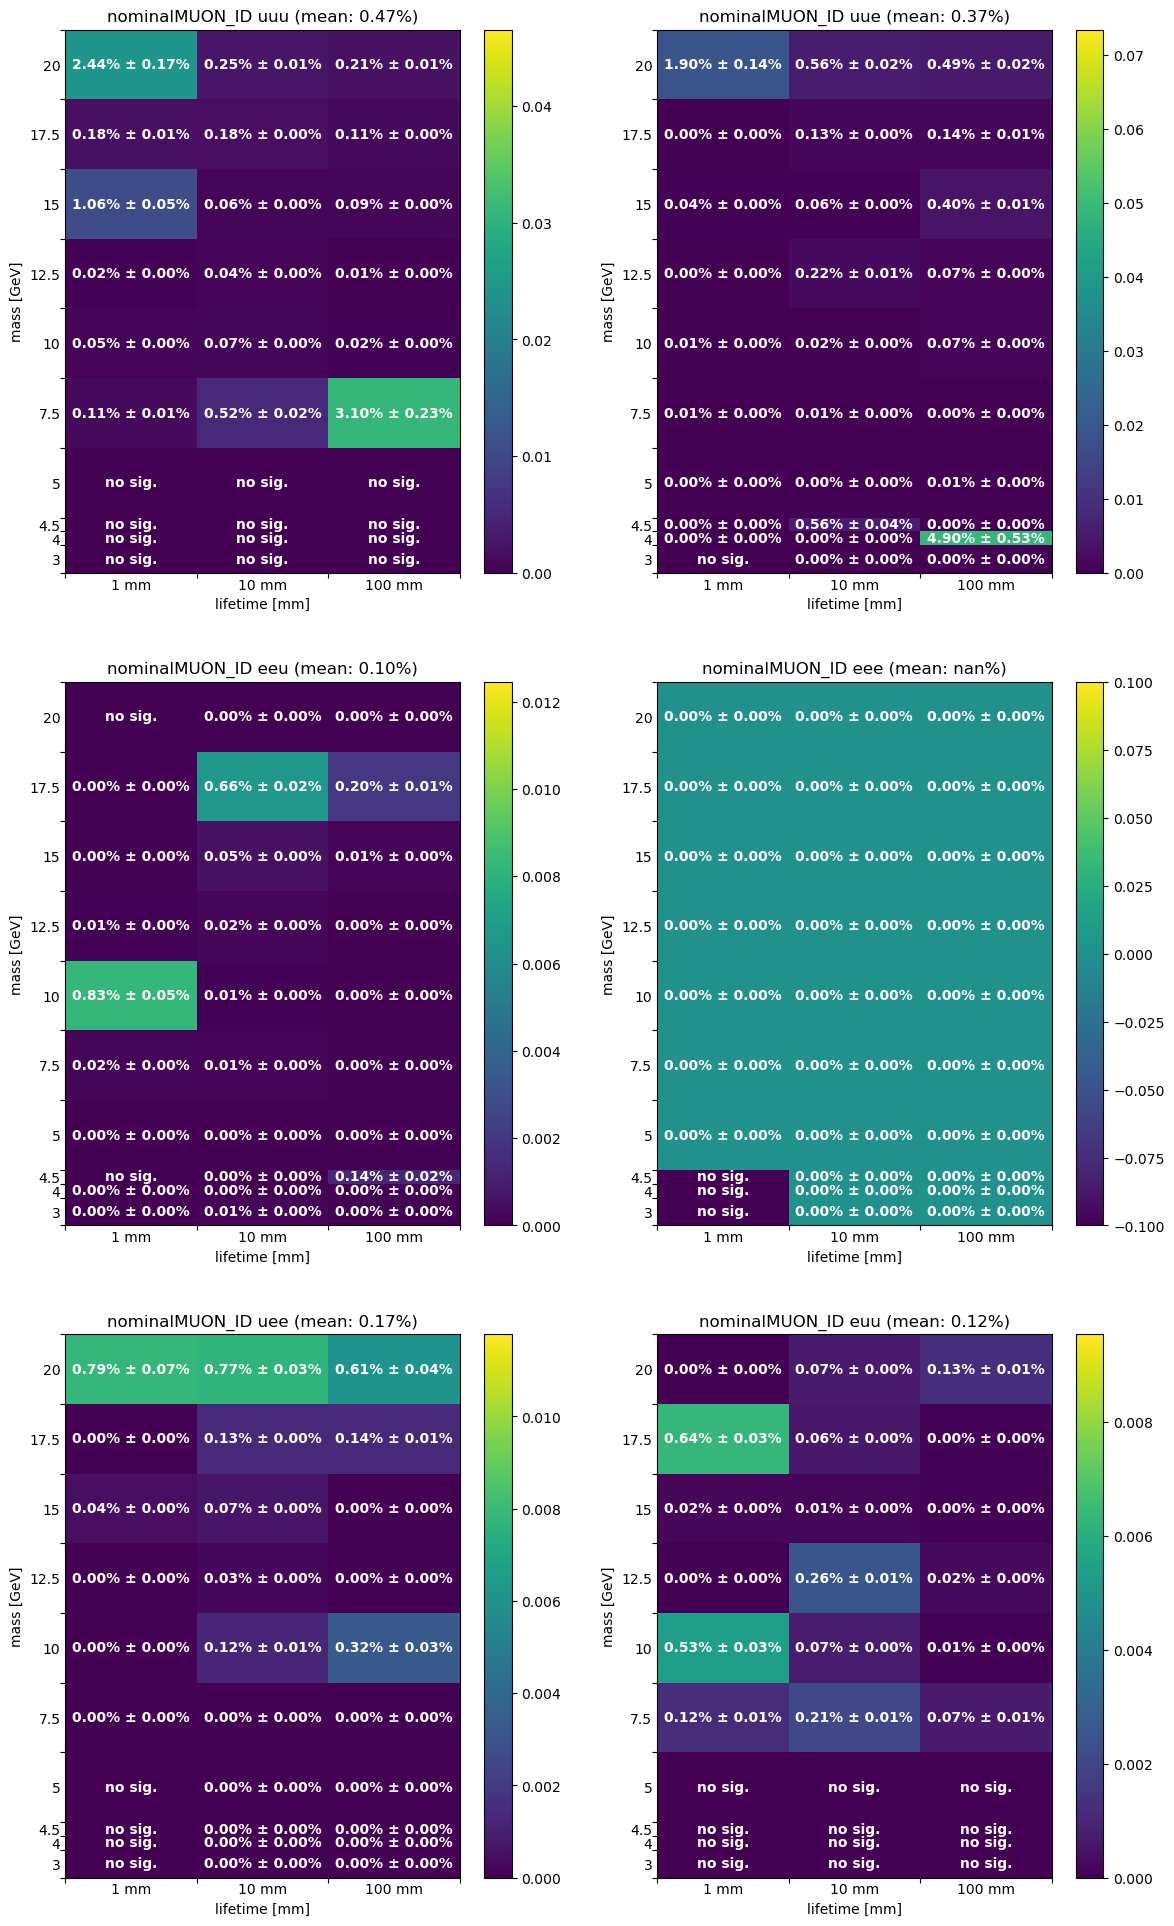

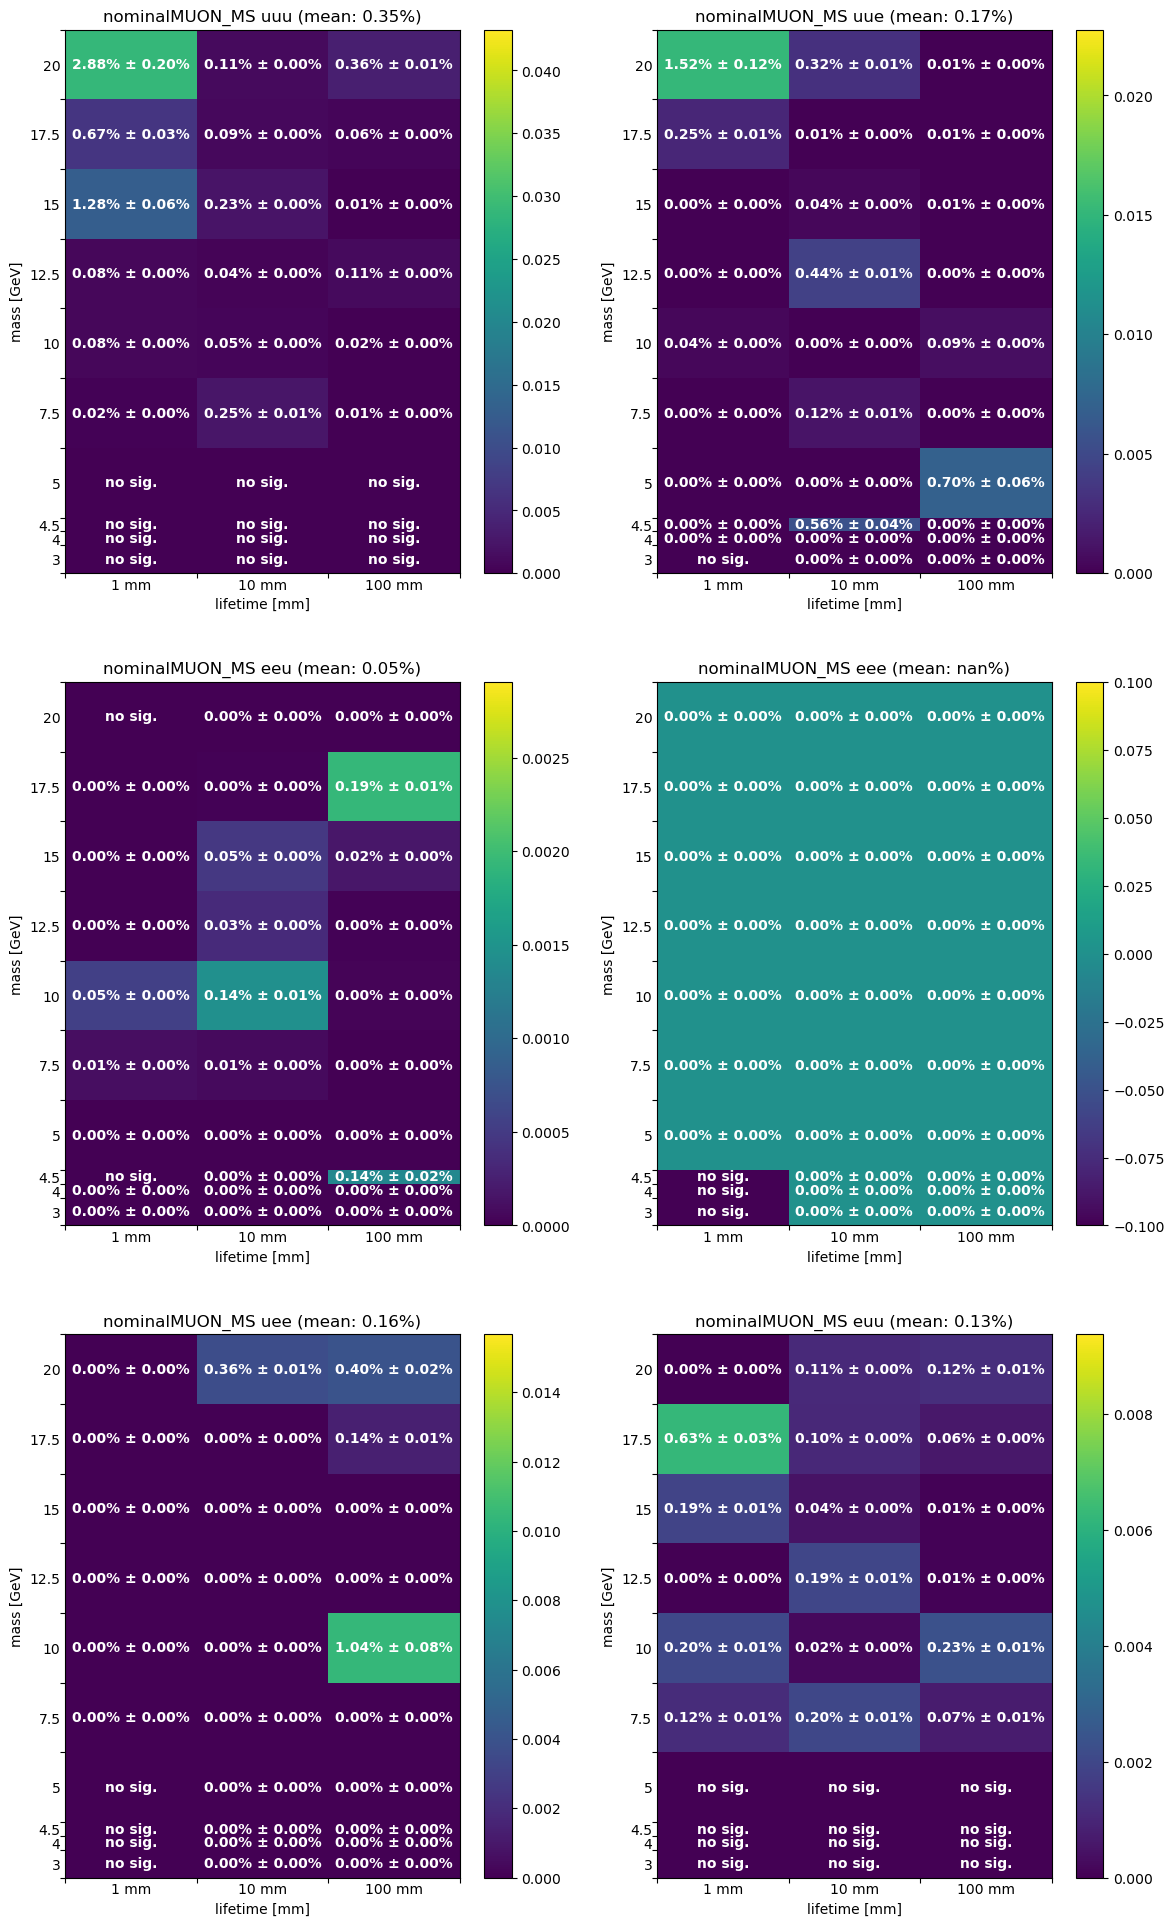

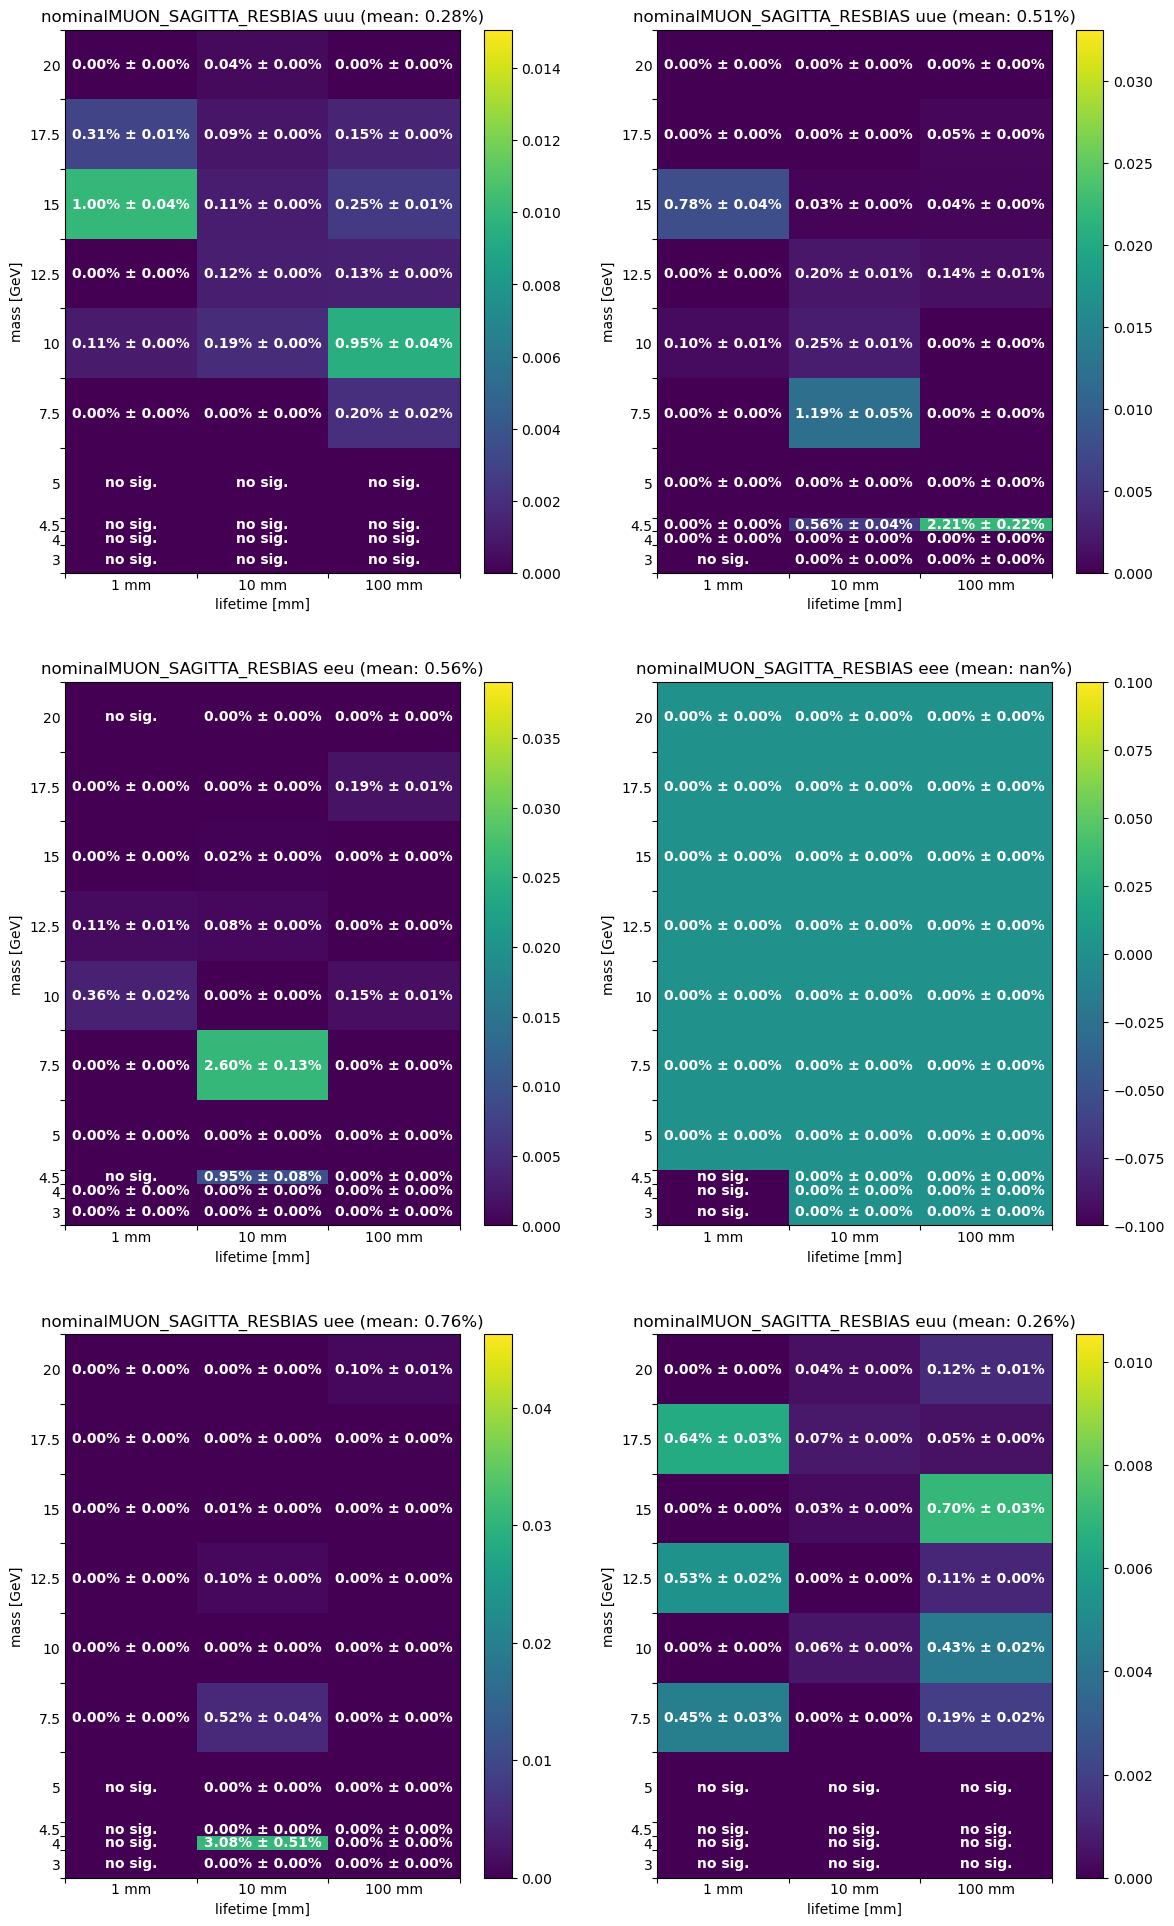

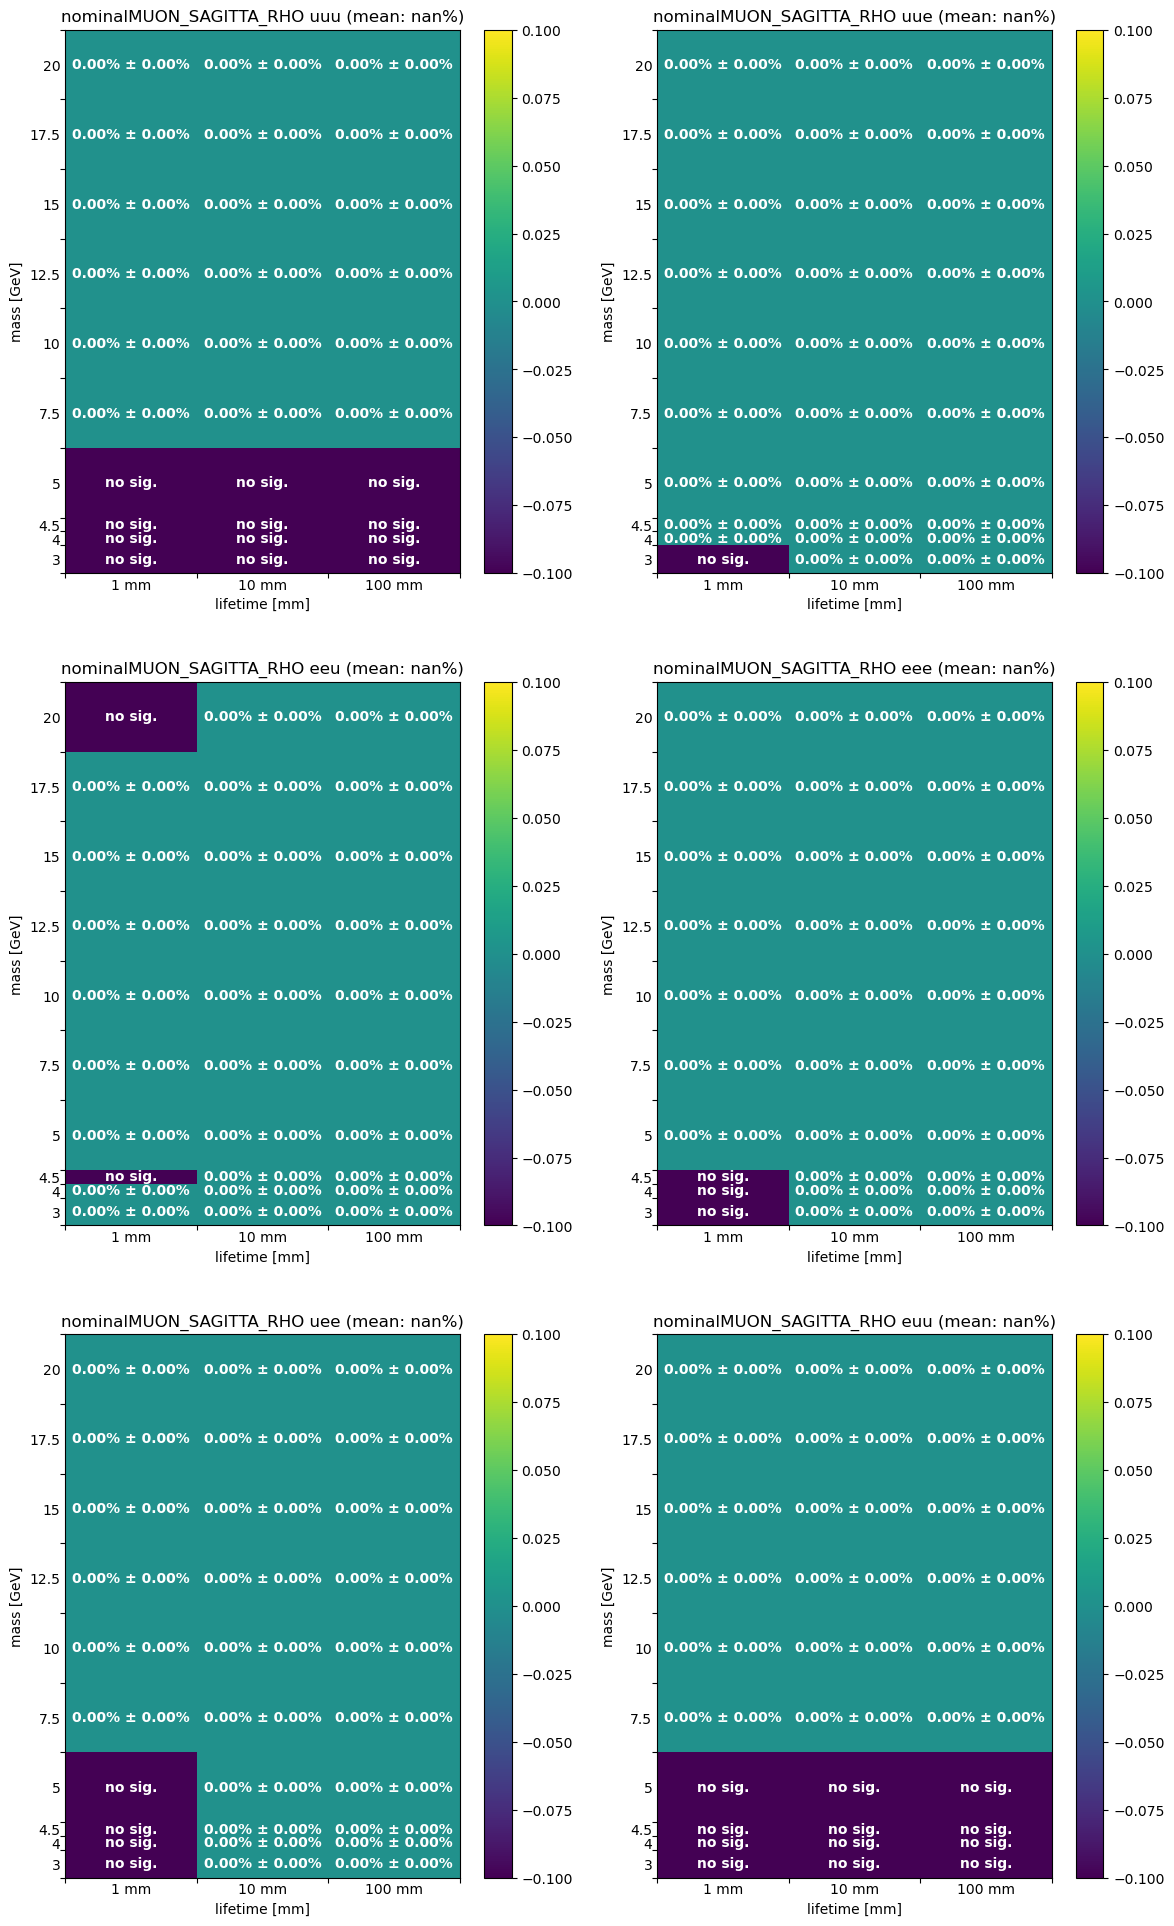

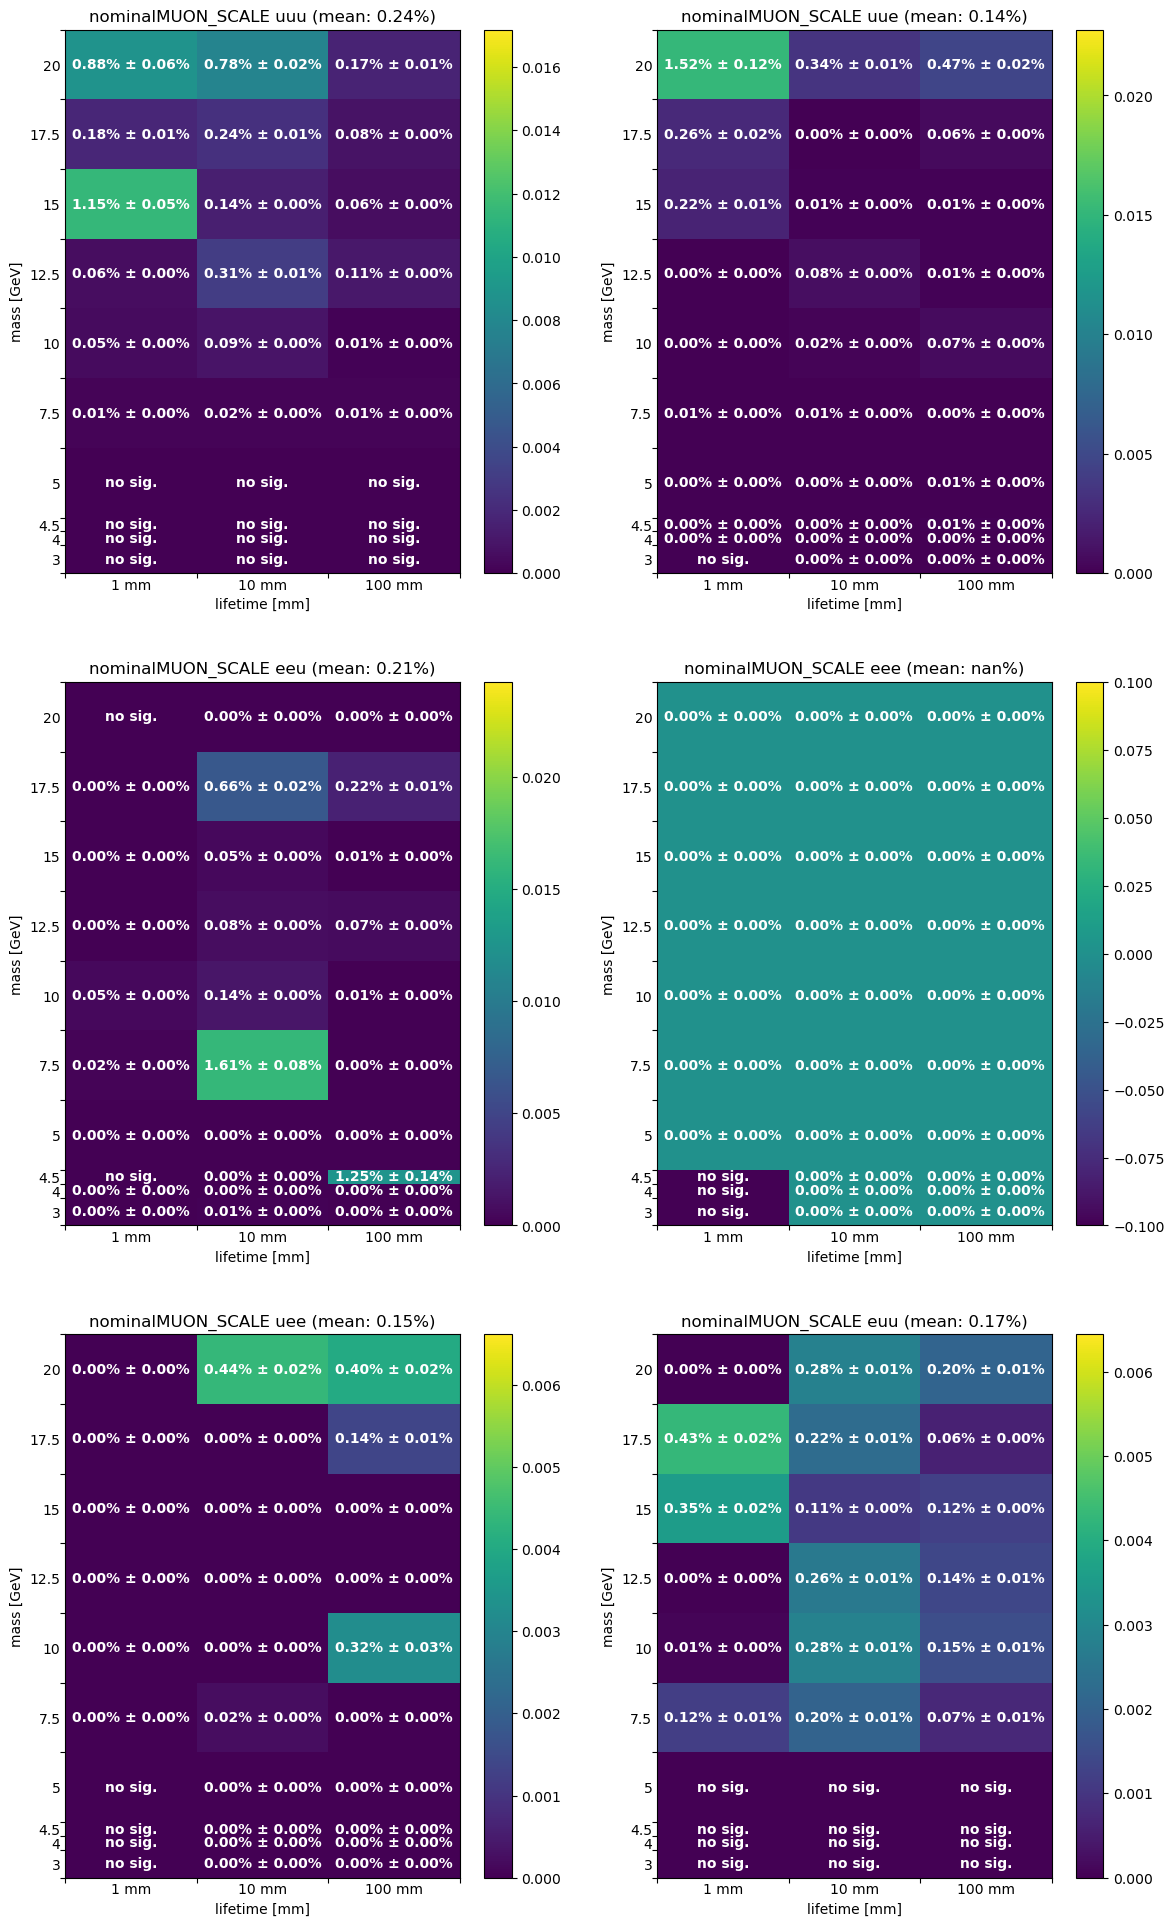

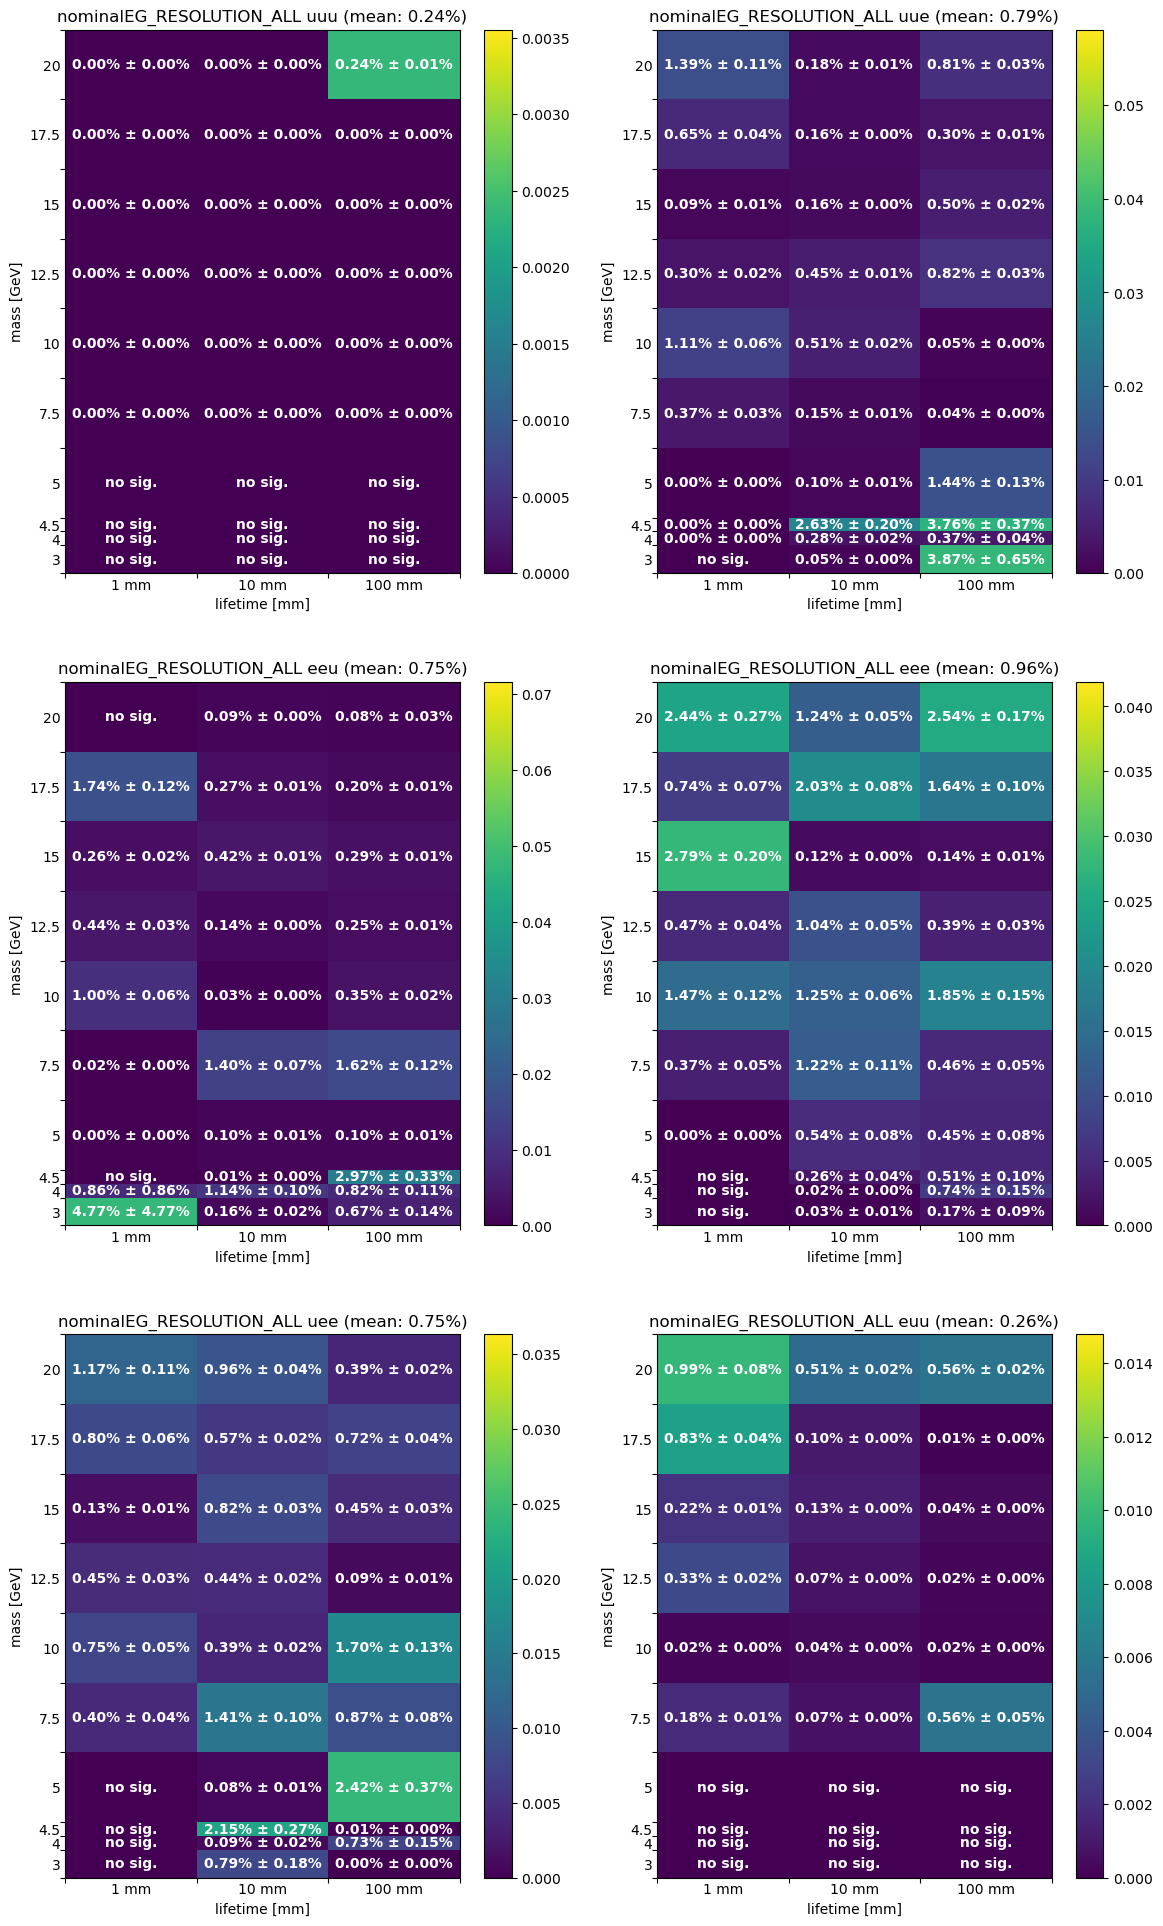

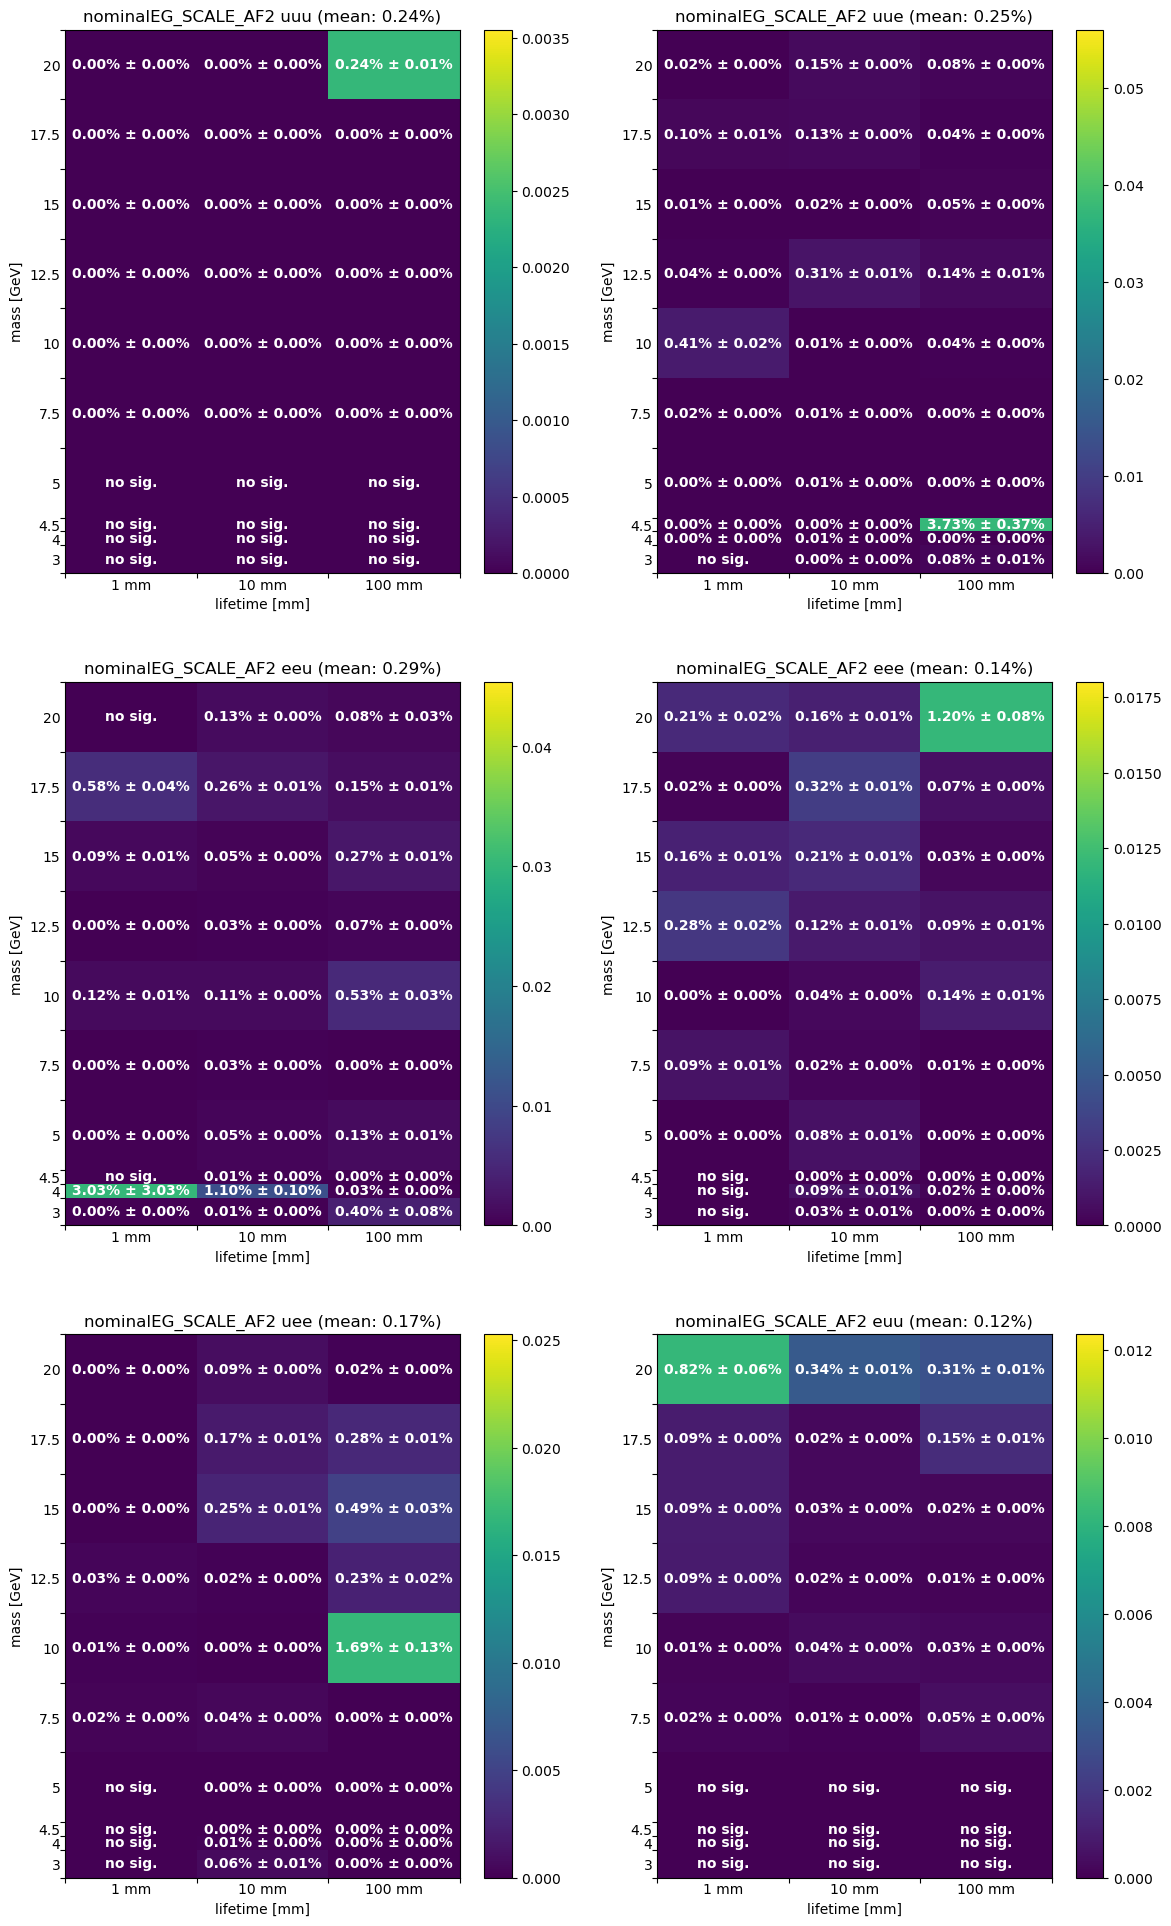

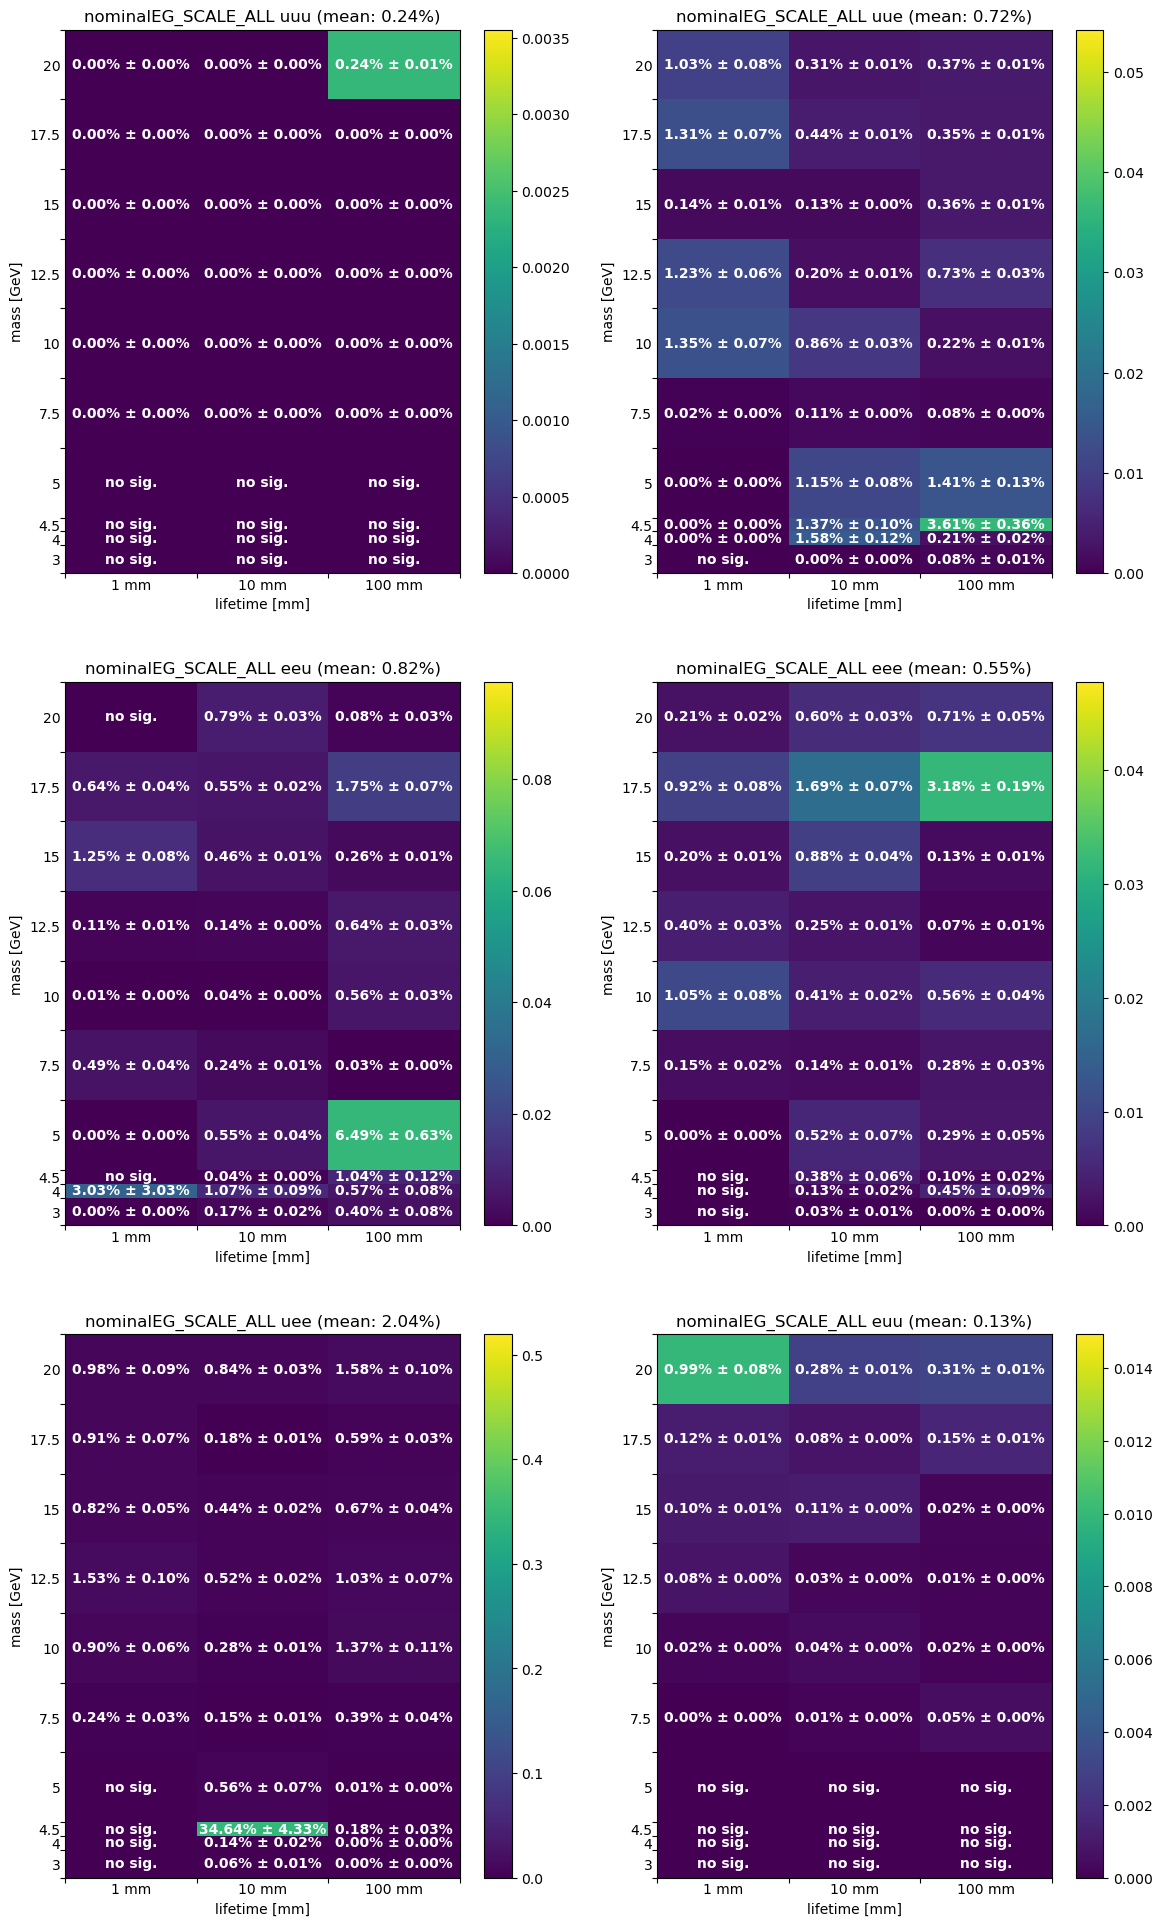

In [59]:

def plot_uncertainties(uncertianty_arr, count_arr, title, ax):
    # plt.figure(figsize=[7,8])
    im = ax.pcolormesh([0,1,2,3], masses, uncertianty_arr, vmin=0, vmax=uncertianty_arr.max()*1.5)
    plt.colorbar(im, ax=ax)
    # ax = plt.gca()

    # mess with x ticks
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels('')
    ax.set_xticklabels(['1 mm', '10 mm', '100 mm',], minor=True)
    ax.set_xticks([0.5,1.5,2.5,], minor=True)
    ax.tick_params(axis='both', which='minor', length=0)

    # mess with y ticks
    ax.set_yticks(masses)
    ax.set_yticklabels('')
    ax.tick_params(which='minor', length=0)
    ax.set_yticks(masses[:-1] + np.diff(masses)/2, minor=True)
    ax.set_yticklabels(masses[:-1], minor=True)

    ax.set_title(title)
    ax.set_xlabel('lifetime [mm]')
    ax.set_ylabel('mass [GeV]')

    # set text
    for i in range(len(masses)-1):
        for j in range(len(lifetimes)):
            yloc = j+.5
            xloc = masses[i] + (masses[i+1]-masses[i])/2
            if uncertianty_arr[i,j] >= 0:
                text = f'{uncertianty_arr[i,j]:0.2%} ± {uncertianty_arr[i,j]/np.sqrt(count_arr[i,j]):.2%}' # percent uncertainty
                # text = f'{uncertianty_arr[i,j]:0.2%} ({int(count_arr[i,j])})' # nevents used
            else:
                text = 'no sig.'
            ax.text(yloc, xloc , text,
                    ha="center", va="center", color="w", fontweight='bold', transform=ax.transData)






channel_list = ['uuu','uue','eeu','eee','uee','euu']
for syst, syst_list, count_list in zip(uncertianty_arr_dict.keys(), uncertianty_arr_dict.values(), count_arr_dict.values()) :
    fig, axs = plt.subplots(3, 2, figsize=[14,24])
    ax_dict = {
        'uuu': axs[0,0],
        'uue': axs[0,1],
        'eeu': axs[1,0],
        'eee': axs[1,1],
        'uee': axs[2,0],
        'euu': axs[2,1],
    }
    for channel, uncertianty_arr, count_arr in zip(channel_list, syst_list, count_list):
        # print(syst, channel, uncertianty_arr, count_arr, sep='\n', end='\n\n')

        syst_mean = np.nan
        syst_mean = uncertianty_arr[uncertianty_arr>0].mean()

        plot_uncertainties(uncertianty_arr, count_arr, title=f'{syst} {channel} (mean: {syst_mean:0.2%})', ax=ax_dict[channel])

    plt.savefig('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/'+syst+'.png', dpi=300)
    plt.savefig('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/pdf/'+syst+'.pdf', dpi=300)

plt.show()

    # break

In [63]:
empty_syst_array = np.array([
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    ])

lepton_reco_syst = {}
lepton_trigger_syst = {}
total_syst = {}
for channel in channel_list:
    lepton_reco_syst[channel] = np.array(empty_syst_array)
    lepton_trigger_syst[channel] = np.array(empty_syst_array)
    total_syst[channel] = np.array(empty_syst_array)


for syst, syst_list, count_list in zip(uncertianty_arr_dict.keys(), uncertianty_arr_dict.values(), count_arr_dict.values()) :
    print(syst)
    for channel, uncertianty_arr, count_arr in zip(channel_list, syst_list, count_list):
        # print(syst, channel, uncertianty_arr, count_arr, sep='\n', end='\n\n')
        # print(lepton_reco_syst[channel])
        uncertianty_arr[uncertianty_arr == -100] = 0

        if 'Trig' in syst:
            lepton_trigger_syst[channel] += np.square(uncertianty_arr)
        elif '_EFF_' in syst or 'nominal' in syst:
            lepton_reco_syst[channel] += np.square(uncertianty_arr)
        else: pass
        total_syst[channel] += np.square(uncertianty_arr)

for channel in channel_list:
    # print('lepton reco syst total mean:', 'channel:', channel, f'{np.sqrt(lepton_reco_syst[channel]).mean():.2%}')
    # print('lepton reco syst total max:', 'channel:', channel, f'{np.sqrt(lepton_reco_syst[channel]).max():.2%}')
    # print('lepton trig syst total mean:', 'channel:', channel, f'{np.sqrt(lepton_trigger_syst[channel]).mean():.2%}')
    # print('lepton trig syst total max:', 'channel:', channel, f'{np.sqrt(lepton_trigger_syst[channel]).max():.2%}')
    print('lepton trig syst total max:', 'channel:', channel, f'{np.sqrt(total_syst[channel] + 0.006389).min():.2%}')

    print()

vertexing_1DOWN
d0_extrapolation_1DOWN
MUON_EFF_RECO_SYS
MUON_EFF_RECO_SYS_LOWPT
MUON_EFF_TrigSystUncertainty
EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR
EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR
EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR
nominalMUON_ID
nominalMUON_MS
nominalMUON_SAGITTA_RESBIAS
nominalMUON_SAGITTA_RHO
nominalMUON_SCALE
nominalEG_RESOLUTION_ALL
nominalEG_SCALE_AF2
nominalEG_SCALE_ALL
lepton trig syst total max: channel: uuu 7.99%

lepton trig syst total max: channel: uue 7.99%

lepton trig syst total max: channel: eeu 7.99%

lepton trig syst total max: channel: eee 7.99%

lepton trig syst total max: channel: uee 7.99%

lepton trig syst total max: channel: euu 7.99%



In [61]:
print('reco mean overall mean', f'{np.mean([np.sqrt(lepton_reco_syst[channel]).mean() for channel in channel_list]):.2%}')
print('reco mean overall max', f'{np.max([np.sqrt(lepton_reco_syst[channel]).mean() for channel in channel_list]):.2%}')
print('trig mean overall mean', f'{np.mean([np.sqrt(lepton_trigger_syst[channel]).mean() for channel in channel_list]):.2%}')
print('trig mean overall max', f'{np.max([np.sqrt(lepton_trigger_syst[channel]).mean() for channel in channel_list]):.2%}')

reco mean overall mean 5.74%
reco mean overall max 11.19%
trig mean overall mean 0.34%
trig mean overall max 0.56%


In [ ]:
impact_dict_mean = {}
impact_dict_max = {}
for k, v in uncertianty_arr_dict.items():
    list_of_uncertainties = []
    max_uncertainty = -1
    # print()
    for channel, a in zip(['uuu','uue','eeu','eee','uee','euu'], v):
        # a = vv[0]
        # print(k, channel)
        # print(a[a>0].mean())
        # print()
        try:
            if a[a>0].max() > max_uncertainty:
                max_uncertainty = a[a>0].max()
            if not np.isnan(a[a>0].mean()):
                list_of_uncertainties.append(a[a>0].mean())
        except: pass
    # print(k, list_of_uncertainties)
    try:
        impact_dict_mean[k] = np.mean(list_of_uncertainties)
        impact_dict_max[k] = max_uncertainty
    except: pass
# print()
# impact_dict

In [ ]:
for k, impact_mean, impact_max in zip(impact_dict_mean.keys(), impact_dict_mean.values(), impact_dict_max.values()):
    print(f'{k}, {impact_mean:.2%}, {impact_max:.2%}')

In [ ]:
import glob
import os
import PyPDF2

merger = PyPDF2.PdfFileMerger()

for f in sorted(glob.glob('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/pdf/*'), key=os.path.getmtime):
    # print(f)
    merger.append(f)

merger.write("/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/systematics_impact.pdf")
merger.close()

In [ ]:
np.sqrt(
    uncertianty_arr_dict['MUON_EFF_RECO_SYS'][0]**2 + 
    uncertianty_arr_dict['MUON_EFF_TrigSystUncertainty'][0]**2
    )

In [ ]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

# nominal = uproot.open('/data/hnl/histograms/v9p2_histograms/histograms_fullrun2_10G_10mm_uuu.root')['nominal']['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL'].pandas.df()
nominalMUON_SAGITTA_RESBIAS__1down = uproot.open('/data/hnl/histograms/v9p2_histograms/histograms_fullrun2_10G_10mm_uuu.root')['nominalMUON_MS__1down']['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['HNLm'].array()
nominalMUON_SAGITTA_RESBIAS__1up = uproot.open('/data/hnl/histograms/v9p2_histograms/histograms_fullrun2_10G_10mm_uuu.root')['nominalMUON_MS__1up']['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['HNLm'].array()
df = pd.DataFrame()
df['nominalMUON_SAGITTA_RESBIAS__1up'] = nominalMUON_SAGITTA_RESBIAS__1up
df['nominalMUON_SAGITTA_RESBIAS__1down'] = nominalMUON_SAGITTA_RESBIAS__1down
df['diff'] = nominalMUON_SAGITTA_RESBIAS__1up - nominalMUON_SAGITTA_RESBIAS__1down
df['diff'].hist(bins=60)
plt.show()
df['diff'].value_counts()

In [ ]:
down = uproot.open('/data/hnl/histograms/v9p2_histograms/histograms_fullrun2_10G_1mm_uuu.root')['nominalMUON_MS__1down']['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL'].pandas.df()
up = uproot.open('/data/hnl/histograms/v9p2_histograms/histograms_fullrun2_10G_1mm_uuu.root')['nominalMUON_MS__1up']['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL'].pandas.df()
diff = down - up

In [ ]:
[print(x) for x in uproot.open('/data/hnl/histograms/v9p2_histograms/histograms_fullrun2_10G_1mm_uuu.root')['nominal']['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL'].keys()];
b'SF_nominal'
b'SF_MUON_EFF_RECO_SYS__1down'
b'SF_MUON_EFF_RECO_SYS__1up'
b'SF_EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR__1down'
b'SF_EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR__1up'
b'SF_EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR__1down'
b'SF_EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR__1up'
b'SF_MUON_EFF_TrigSystUncertainty__1down'
b'SF_MUON_EFF_TrigSystUncertainty__1up'
b'SF_EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR__1down'
b'SF_EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR__1up'
b'SF_weight_pileup_up'
b'SF_weight_pileup_down'
b'model_weight_one_majorana_hnl_LNCplusLNV_single_flavour_mixing'
b'model_weight_quasi_dirac_pair_LNCplusLNV_ih_mixing'
b'model_weight_quasi_dirac_pair_LNCplusLNV_nh_mixing'
b'model_weight_one_dirac_hnl_LNC_single_flavour_mixing'
b'model_weight_quasi_dirac_pair_LNC_ih_mixing'
b'model_weight_quasi_dirac_pair_LNC_nh_mixing'
b'LNC_xsec_one_majorana_hnl_single_flavour'
b'LNC_xsec_one_dirac_hnl_single_flavour'
b'NH_xsec'
b'IH_xsec'
b'event_is_LNC'
b'event_is_LNV'
b'plep_pt'
b'plep_eta'
b'plep_phi'
b'plep_d0'
b'plep_z0'
b'plep_charge'
b'plep_isTight'
b'plep_is_trigger_matched'
b'mvis'
b'mtrans'
b'HNLm'
b'HNLm_altbinning'
b'alt_HNLm'
b'HNLm_fixWmass'
b'HNLpt'
b'HNLeta'
b'HNLphi'
b'DV_redmass'
b'DV_redmassvis'
b'DV_redmassHNL'
b'mll_dMu_plep_is_OS'
b'mll_dMu_plep_is_SS'
b'mll_dMu_plep'
b'DV_trk_deta'
b'DV_trk_dphi'
b'DV_trk_dpt'
b'DV_trk_dR'
b'DV_cosmic_sep'
b'DV_trk_max_chi2_toSV'
b'DV_trk_min_chi2_toSV'
b'DV_trk_max_d0_wrtSV'
b'DV_trk_min_d0_wrtSV'
b'DV_trk_max_errd0_wrtSV'
b'DV_trk_min_errd0_wrtSV'
b'DV_trk_max_z0_wrtSV'
b'DV_trk_min_z0_wrtSV'
b'DV_trk_max_errz0_wrtSV'
b'DV_trk_min_errz0_wrtSV'
b'DV_mumu'
b'DV_ee'
b'DV_emu'
b'DV_1lep'
b'DV_pass_el_mu_overlap'
b'DV_pass_lep_pt'
b'DV_trk_0_pt'
b'DV_trk_0_eta'
b'DV_trk_0_phi'
b'DV_trk_0_d0'
b'DV_trk_0_z0'
b'DV_trk_0_charge'
b'DV_trk_0_chi2'
b'DV_trk_0_isSelected'
b'DV_trk_0_isAssociated'
b'DV_trk_0_mom_parall'
b'DV_trk_0_mom_perp'
b'DV_trk_0_mom_mag'
b'DV_trk_0_mom_frac_parall'
b'DV_trk_1_pt'
b'DV_trk_1_eta'
b'DV_trk_1_phi'
b'DV_trk_1_d0'
b'DV_trk_1_z0'
b'DV_trk_1_charge'
b'DV_trk_1_chi2'
b'DV_trk_1_isSelected'
b'DV_trk_1_isAssociated'
b'DV_trk_1_mom_parall'
b'DV_trk_1_mom_perp'
b'DV_trk_1_mom_mag'
b'DV_trk_1_mom_frac_parall'
b'DV_mu_0_trk_pt_wrtSV'
b'DV_mu_1_trk_pt_wrtSV'
b'DV_mu_0_std_trk_pt'
b'DV_mu_1_std_trk_pt'
b'DV_mu_0_lepmatched_trk_pt'
b'DV_mu_1_lepmatched_trk_pt'
b'DV_mu_0_lepmatched_trk_eta'
b'DV_mu_1_lepmatched_trk_eta'
b'DV_mu_0_lepmatched_trk_phi'
b'DV_mu_1_lepmatched_trk_phi'
b'DV_mass_lepmatched'
b'DV_mass_diff'
b'DV_mu_0_pt_diff'
b'DV_mu_1_pt_diff'
b'DV_mu_0_pt_diff_lep_matched'
b'DV_mu_1_pt_diff_lep_matched'
b'DV_mu_0_is_trigger_matched'
b'DV_mu_1_is_trigger_matched'
b'DV_mu_0_isMuon'
b'DV_mu_1_isMuon'
b'DV_mu_0_charge'
b'DV_mu_1_charge'
b'DV_mu_0_isElectron'
b'DV_mu_1_isElectron'
b'DV_mu_0_muon_isLoose'
b'DV_mu_1_muon_isLoose'
b'DV_mu_0_muon_isMedium'
b'DV_mu_1_muon_isMedium'
b'DV_mu_0_muon_isTight'
b'DV_mu_1_muon_isTight'
b'DV_mu_trk_pt'
b'DV_mu_trk_eta'
b'DV_mu_trk_phi'
b'DV_trk_pt'
b'DV_trk_eta'
b'DV_trk_phi'
b'DV_trk_d0'
b'DV_trk_z0'
b'DV_trk_absz0'
b'DV_trk_charge'
b'DV_trk_chi2'
b'DV_trk_isLRT'
b'DV_trk_isSelected'
b'DV_trk_isAssociated'
b'DV_trk_nPixelHits'
b'DV_trk_nSCTHits'
b'DV_trk_nSiHits'
b'DV_trk_chi2_toSV'
b'DV_trk_d0_wrtSV'
b'DV_trk_errd0_wrtSV'
b'DV_trk_z0_wrtSV'
b'DV_trk_errz0_wrtSV'
b'DV_num_trks'
b'DV_x'
b'DV_y'
b'DV_z'
b'DV_r'
b'PV_x'
b'PV_y'
b'PV_z'
b'DV_distFromPV'
b'DV_mass'
b'DV_pt'
b'DV_eta'
b'DV_phi'
b'DV_minOpAng'
b'DV_maxOpAng'
b'DV_charge'
b'DV_chi2'
b'DV_max_dR'
b'DV_max_dR_wrtSV'
b'DV_maxd0'
b'DV_mind0'
b'DV_ntrk'
b'DV_ntrk_lrt'
b'DV_ntrk_sel'
b'DV_ntrk_assoc'
b'DV_pass_mat_veto'
b'DV_truth_matched'
b'properLifetime'
b'DV_trk_0_d0_truth'
b'DV_trk_1_d0_truth'
b'DV_trk_v_mu_pt'
b'DV_alpha'
b'DV_2tight'
b'DV_2medium'
b'DV_2loose'
b'DV_1tight'
b'DV_1medium'
b'DV_1loose'
b'DV_tight_loose'
b'DV_tight_medium'
b'DV_medium_loose'
b'DV_tight_veryloose'
b'DV_medium_veryloose'
b'DV_loose_veryloose'
b'DV_tight_veryveryloose'
b'DV_medium_veryveryloose'
b'DV_loose_veryveryloose'
b'DV_2veryveryloose'
b'DV_1veryveryloose'
b'n_trigger_matched_medium'
b'vertexing_1DOWN'
b'd0_extrapolation_1DOWN'


In [15]:

mean_uncertainty = 1 - uproot.open('/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_10G_10mm_uuu.root')['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['vertexing_1DOWN'].array().mean()
mean_uncertainty = 1 - uproot.open('/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_10G_10mm_uuu.root')['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['d0_extrapolation_1DOWN'].array().mean()
mean_uncertainty

0.02191968112101983

In [17]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image


masses = [3, 4, 4.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5]
lifetimes = {1:0, 10:1, 100:2}

def set_bin_content(mass, lifetime, value, arr):
    ybin = np.max(np.digitize(mass, masses)-1, 0)
    xbin = lifetimes[lifetime]
    arr[ybin,xbin] = value

def calculate_tree_syst(nominal_tree, variation_tree):
    model = 'model_weight_one_dirac_hnl_LNC_single_flavour_mixing' # yes this is arbitrary, and yes it does change the return value
    # make histograms
    n_nom, bins_nom = np.histogram(nominal_tree['HNLm'].array(), bins=np.linspace(0,100,100), weights=nominal_tree[model].array() * nominal_tree['SF_nominal'].array())
    n_var, bins_var = np.histogram(variation_tree['HNLm'].array(), bins=np.linspace(0,100,100), weights=variation_tree[model].array() * variation_tree['SF_nominal'].array())
    bin_width = bins_nom[1] - bins_nom[0] # should be the same as var

    # sum over number in each bin and mult by bin width, which can be factored out
    integral_nom = bin_width * sum(n_nom)
    integral_var = bin_width * sum(n_var)

    syst = abs((integral_nom - integral_var) / integral_nom )

    return syst

def make_uncertainty_plot(histpath, title):

    uncertianty_arr = np.array([
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    ])

    count_arr = np.array(uncertianty_arr)

    # get bins from ntuples    
    for hist_file in glob.glob(histpath):

        f_fullrun2 = uproot.open(hist_file)
        uncertainty_value = -100
        passed_events = -100
        try:
            # take the per-event difference in systematics
            if TREE_SYSTEMATIC:
                nominal_tree = f_fullrun2[f'nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']
                down_tree = f_fullrun2[f'{sys_of_interest}__1up_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']
                up_tree = f_fullrun2[f'{sys_of_interest}__1down_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']
                up_variation = calculate_tree_syst(nominal_tree, up_tree)
                down_variation = calculate_tree_syst(nominal_tree, down_tree)
                uncertainty_value = max(up_variation, down_variation) # maximum symmetrization used in limits
            else:
                uncertainty_value = 1 - f_fullrun2['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL'][sys_of_interest].array().mean()
            passed_events = len(f_fullrun2['nominal_VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['SF_nominal'])
        except Exception as e:
            # print('failure', hist_file)
            # print(e)
            pass

        tokens = hist_file.split('/')[5].split('_')
        file_lifetime = int(tokens[3].split('mm')[0])
        file_mass = float(tokens[2][:-1].replace('p','.'))
        set_bin_content(file_mass, file_lifetime, uncertainty_value, uncertianty_arr)
        set_bin_content(file_mass, file_lifetime, passed_events, count_arr)

    return uncertianty_arr, count_arr

DO_DISPLAY = False

uncertianty_arr_dict = {}
count_arr_dict = {}

for sys_of_interest in [# SFs
                        'vertexing_1DOWN',
                        'd0_extrapolation_1DOWN'
                        ]:

    if 'nominal' in sys_of_interest:
        TREE_SYSTEMATIC = True
    else:
        TREE_SYSTEMATIC = False

                        
    # fig, axs = plt.subplots(2, 2, figsize=[14,16])

    uncertianty_arr_list = []
    count_arr_list = []

    print(sys_of_interest, 'uuu')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_uuu.root', title=f'{sys_of_interest} μμμ')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/uuu_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'uue')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_uue.root', title=f'{sys_of_interest} μμe')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/uue_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'eeu')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_eeu.root', title=f'{sys_of_interest} eeμ')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/eeu_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'eee')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_eee.root', title=f'{sys_of_interest} eee')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/eee_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'uee')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_uee.root', title=f'{sys_of_interest} μee')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/uee_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)

    print(sys_of_interest, 'euu')
    uncertianty_arr, count_arr = make_uncertainty_plot(histpath='/data/hnl/histograms/v9p3_histograms/histograms_fullrun2_*_euu.root', title=f'{sys_of_interest} eμμ')
    if DO_DISPLAY: display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/euu_{sys_of_interest}.png'));
    uncertianty_arr_list.append(uncertianty_arr)
    count_arr_list.append(count_arr)


    # plt.savefig('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/png/'+sys_of_interest+'.png', dpi=300)
    # plt.savefig('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/leptons/plots/pdf/'+sys_of_interest+'.pdf', dpi=300)

    uncertianty_arr_dict[sys_of_interest] = uncertianty_arr_list
    count_arr_dict[sys_of_interest] = count_arr_list




vertexing_1DOWN uuu
vertexing_1DOWN uue
vertexing_1DOWN eeu
vertexing_1DOWN eee
vertexing_1DOWN uee
vertexing_1DOWN euu
d0_extrapolation_1DOWN uuu
d0_extrapolation_1DOWN uue
d0_extrapolation_1DOWN eeu
d0_extrapolation_1DOWN eee
d0_extrapolation_1DOWN uee
d0_extrapolation_1DOWN euu


In [46]:

channel_list = ['uuu','uue','eeu','eee','uee','euu']
d0_extrap = {}
vertexing = {}
for syst, syst_list, count_list in zip(uncertianty_arr_dict.keys(), uncertianty_arr_dict.values(), count_arr_dict.values()) :
    for channel, uncertianty_arr, count_arr in zip(channel_list, syst_list, count_list):
        # print(syst, channel, uncertianty_arr, count_arr, sep='\n', end='\n\n')
        # print(lepton_reco_syst[channel])
        uncertianty_arr[uncertianty_arr == -100] = 0
        if syst == 'd0_extrapolation_1DOWN':
            d0_extrap[channel] = uncertianty_arr.max()
        if syst == 'vertexing_1DOWN':
            vertexing[channel] = uncertianty_arr.max()


for channel in ['eee', 'uee', 'eeu', 'uue', 'euu', 'uuu',]:
    print(f'{vertexing[channel]*100:.1f}', end=' & ')
    # print(channel, end=' & ')


19.6 & 18.9 & 28.2 & 20.6 & 9.1 & 10.8 & 

In [ ]:
19.6 & 18.9 & 28.2 & 20.6 & 9.1 & 10.8 &

In [47]:
uncertianty_arr_dict_backup

NameError: name 'uncertianty_arr_dict_backup' is not defined